In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F
from training_utils import double_std, plot_losses

import json
import statistics
from sklearn.metrics import f1_score
import pickle
import seaborn as sns

import scipy.stats as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_losses(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)
    
    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses.plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')

    plt.figure()

In [3]:
def t_test_calcul(x,y,alternative='both-sided'):
    _, double_p = sp.ttest_ind(x,y,equal_var = False)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return pval

In [4]:
def plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False, 
                 last_epoch = False, n_val = 2, recall_precision = False) :
    if recall_precision :
        results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch', 'recall','precision'])
    else :
        results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        if last_epoch and pretraining != 'baseline':
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_'+str(n_val)+'_vol_in_val_pretrainedEpoch1499/run_' + str(run)
                        else : 
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_'+str(n_val)+'_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results_2.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
    results['model'][results['model'] == 'pretrained with MMWHSC-HCP-Chaos-MedDecath Prostate (global_dminus)'] = 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'

    results["p value"] = 0
    for n_train in results['n vol train'].unique() :
        results_baseline = results.loc[(results['model'] == 'baseline') & (results['n vol train'] == n_train) ]
        for pretraining in results['model'].unique() :
            if pretraining != 'baseline' :
                results_pretrainings = results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train) ,'test F1'] 
                t_test = sp.ttest_ind( results_pretrainings, results_baseline['test F1'], alternative = 'greater')
                results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train), 'p value'] = t_test[1]
                #t_test = t_test_calcul(results_pretrainings, results_baseline['test F1'],alternative='greater')
                #results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train, 'p value'] = t_test

    results_mean = results.groupby([ "n vol train", "model"]).agg([np.mean, double_std, sp.sem])
    results_test_f1 = results_mean['test F1']
    if recall_precision :
        results_recall_precision = results_mean[['recall','precision']]
        
#     mapping = {p: i for i, p in enumerate(pretrainings)}
#     key = results_test_f1['model'].unstack().map(mapping)
#     results_test_f1.iloc[key.argsort()]
    sns.barplot(data=results, y='test F1', x="n vol train", hue="model")
    #results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(-0.05, -0.43))
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    results_test_f1['p value'] = results.groupby( ["n vol train", "model"]).mean()['p value']
    if not recall_precision :
        return results_test_f1, results
    else :
        return results_test_f1, results, results_recall_precision


In [5]:
def boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False, n_val = 2) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 
                                      'validation F1', 'test F1', 'train loss', 
                                      'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_'+str(n_val)+'_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results_2.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
                        
    results['model'][results['model'] == 'pretrained with MMWHSC-HCP-Chaos-MedDecath Prostate (global_dminus)'] = 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
    plt.figure(figsize=(8, 6), dpi=180)
    sns.boxplot(x= results["n vol train"], y = results['test F1'], hue = results["model"],
               showmeans=True, meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                     "markersize":"5"})
    #sns.displot(x= results["n vol train"], y = results['test F1'], hue = results["model"])
    plt.xlabel('number of volumes in trainset', fontsize=15)
    plt.ylabel('mean Dice score', fontsize=15)

    plt.ylim([0, 1])
    plt.legend(loc='center left', bbox_to_anchor=(-0.05, -0.43), fontsize=15) #(1.0, 0.5)) #
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    

In [6]:
def plot_results_per_label(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 
                           dataset, save_file, ordered_diff=None, n_val = 2) :
    results = pd.DataFrame(columns = ["F1 label", "label", "n vol train", "batch_size", "model"])
    
    labels = []
    if dataset == 'ACDC' :
        labels = ['RV', 'Myo', 'LV'] 
        print('here')
    elif dataset == 'CIMAS' :
        labels = ['LV', 'Myo', 'RV'] 
    elif dataset == 'Abide' :
        labels = ["cerebellum GM", "cerebellum WM", "cerebral GM", "cerebral WM",
                  "thalamus ", "hippocampus", "amygdala", "lateral ventricles", 
                  "caudate", "putamen", "pallidum", "ventral Diencephalon", 
                  "third ventricle", "brain stem"] 
    else :
        print('error')
    
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_'+str(n_val)+'_vol_in_val/run_' + str(run)
                        
                        infile = open(save_directory_name + '/results_2.pkl','rb')
                        results_BN = pickle.load(infile)
    
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                    
                            if ordered_diff is not None :
                                if label  in ordered_diff.index[0:4]:
                                    results=results.append(results_BN)
                            else:
                                results=results.append(results_BN)
    plt.figure(figsize=(8, 6), dpi=180)
    results['model'][results['model'] == 'pretrained with MMWHSC-HCP-Chaos-MedDecath Prostate (global_dminus)'] = 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
    
    results_mean = results.groupby([ "label", "model"]).agg([np.mean, double_std, sp.sem])
    results_test_f1 = results_mean['F1 label']
    plt.figure(figsize=(8, 6), dpi=180)
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem",figsize=(8, 6)).get_figure()
    
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    results_test_f1 = results_mean['F1 label']
    return results_test_f1
    

In [7]:
def boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 
                   dataset, save_file, ordered_diff=None, n_val = 2) :
    
    results = pd.DataFrame(columns = ['model', 'n vol train', 'label'])
    
    labels = []
    if dataset == 'ACDC' :
        labels = ['RV', 'Myo', 'LV'] 
        print('here')
    elif dataset == 'CIMAS' :
        labels = ['LV', 'Myo', 'RV'] 
    elif dataset == 'Abide' :
        labels = ["cerebellum GM", "cerebellum WM", "cerebral GM", "cerebral WM",
                  "thalamus ", "hippocampus", "amygdala", "lateral ventricles", 
                  "caudate", "putamen", "pallidum", "ventral Diencephalon", 
                  "third ventricle", "brain stem"] 
    else :
        print('error')
        
    print(labels)
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + \
                                                str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + \
                                                '_' + str(n_train) + \
                                                '_vol_in_train_'+str(n_val)+'_vol_in_val/run_' + str(run)
                        
                            
                        infile = open(save_directory_name + '/results_2.pkl','rb')   
                        results_BN = pickle.load(infile)
    
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            if ordered_diff is not None :
                                if label  in ordered_diff.index[0:4]:
                                    results=results.append(results_BN)
                                
                            elif ordered_diff is None :
                                results=results.append(results_BN)   
    
    results["p value"] = 0
    for n_train in results['n vol train'].unique() :
        for pretraining in results['model'].unique() :
            if pretraining != 'baseline' :   
                for label in results['label'].unique() :
                    results_baseline = results.loc[(results['model'] == 'baseline') & (results['n vol train'] == n_train)& (results['label'] == label) ]
                    results_pretrainings = results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train) & (results['label'] == label) ,'F1 label'] 
                    
                    t_test = sp.ttest_ind(results_pretrainings, results_baseline['F1 label'], alternative = 'greater')
                    
                    results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train)  & (results['label'] == label), 'p value'] = t_test[1]
                    #t_test = t_test_calcul(results_pretrainings, results_baseline['test F1'],alternative='greater')
                    #results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train, 'p value'] = t_test
    
    results_test_f1 = results.groupby(["n vol train", "label", "model"]).mean()['p value']
    results['model'][results['model'] == 'pretrained with MMWHSC-HCP-Chaos-MedDecath Prostate (global_dminus)'] = \
                                         'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
    plt.figure(figsize=(8, 6), dpi=180)
    ax = sns.boxplot(x = results["label"], y = results['F1 label'], hue = results["model"],
                showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
    plt.ylim([0, 1])
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #ax.get_legend().remove()
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    
    
    return results, results_test_f1


In [8]:
def boxplot_labels_mean(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 
                   dataset, save_file, ordered_diff=None, n_val = 2) :
    
    results = pd.DataFrame(columns = ['model', 'n vol train', 'label'])
    
    labels = []
    if dataset == 'ACDC' :
        labels = ['RV', 'Myo', 'LV'] 
        print('here')
    elif dataset == 'CIMAS' :
        labels = ['LV', 'Myo', 'RV'] 
    elif dataset == 'Abide' :
        labels = ["cerebellum GM", "cerebellum WM", "cerebral GM", "cerebral WM",
                  "thalamus ", "hippocampus", "amygdala", "lateral ventricles", 
                  "caudate", "putamen", "pallidum", "ventral Diencephalon", 
                  "third ventricle", "brain stem"] 
    else :
        print('error')
        
    print(labels)
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + \
                                                str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + \
                                                '_' + str(n_train) + \
                                                '_vol_in_train_'+str(n_val)+'_vol_in_val/run_' + str(run)
                        
                            
                        infile = open(save_directory_name + '/results_2.pkl','rb')   
                        results_BN = pickle.load(infile)
    
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            if ordered_diff is not None :
                                if label  in ordered_diff.index[0:4]:
                                    results=results.append(results_BN)
                                
                            elif ordered_diff is None :
                                results=results.append(results_BN)   
    
    results["p value"] = 0
    for n_train in results['n vol train'].unique() :
        for pretraining in results['model'].unique() :
            if pretraining != 'baseline' :   
                for label in results['label'].unique() :
                    results_baseline = results.loc[(results['model'] == 'baseline') & (results['n vol train'] == n_train)& (results['label'] == label) ]
                    results_pretrainings = results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train) & (results['label'] == label) ,'F1 label'] 
                    
                    t_test = sp.ttest_ind(results_pretrainings, results_baseline['F1 label'], alternative = 'greater')
                    
                    results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train)  & (results['label'] == label), 'p value'] = t_test[1]
                    #t_test = t_test_calcul(results_pretrainings, results_baseline['test F1'],alternative='greater')
                    #results.loc[(results['model'] == pretraining) & (results['n vol train'] == n_train, 'p value'] = t_test
    for n_train in results['n vol train'].unique() :         
        results['model'][(results['model'] != 'baseline') & (results['n vol train'] == n_train)] = 'n = ' + str(n_train) + ', pretrained'
        results['model'][(results['model'] == 'baseline') & (results['n vol train'] == n_train)] = 'n = ' + str(n_train) + ', baseline' 

    results_test_f1 = results.groupby(["label", "model", "n vol train"]).mean()['p value']
    
    
    ax = sns.boxplot(x = results["label"], y = results['F1 label'], hue = results["model"], 
                     order = ['RV', 'Myo', 'LV'],
                showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
    plt.ylim([0, 1])
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #ax.get_legend().remove()
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    
    
    return results, results_test_f1


In [9]:
losses = ['crossentropy_loss']
lr = 0.001

# Results ACDC (heart)

,,mean,double_std,sem,p value
n vol train,model,,,,
1,baseline,0.611438,0.122751,0.027448,0
2,baseline,0.737535,0.102677,0.022959,0
5,baseline,0.815617,0.038412,0.008589,0


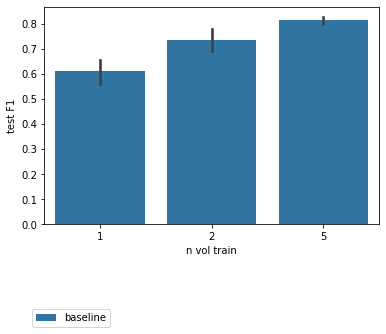

<Figure size 432x288 with 0 Axes>

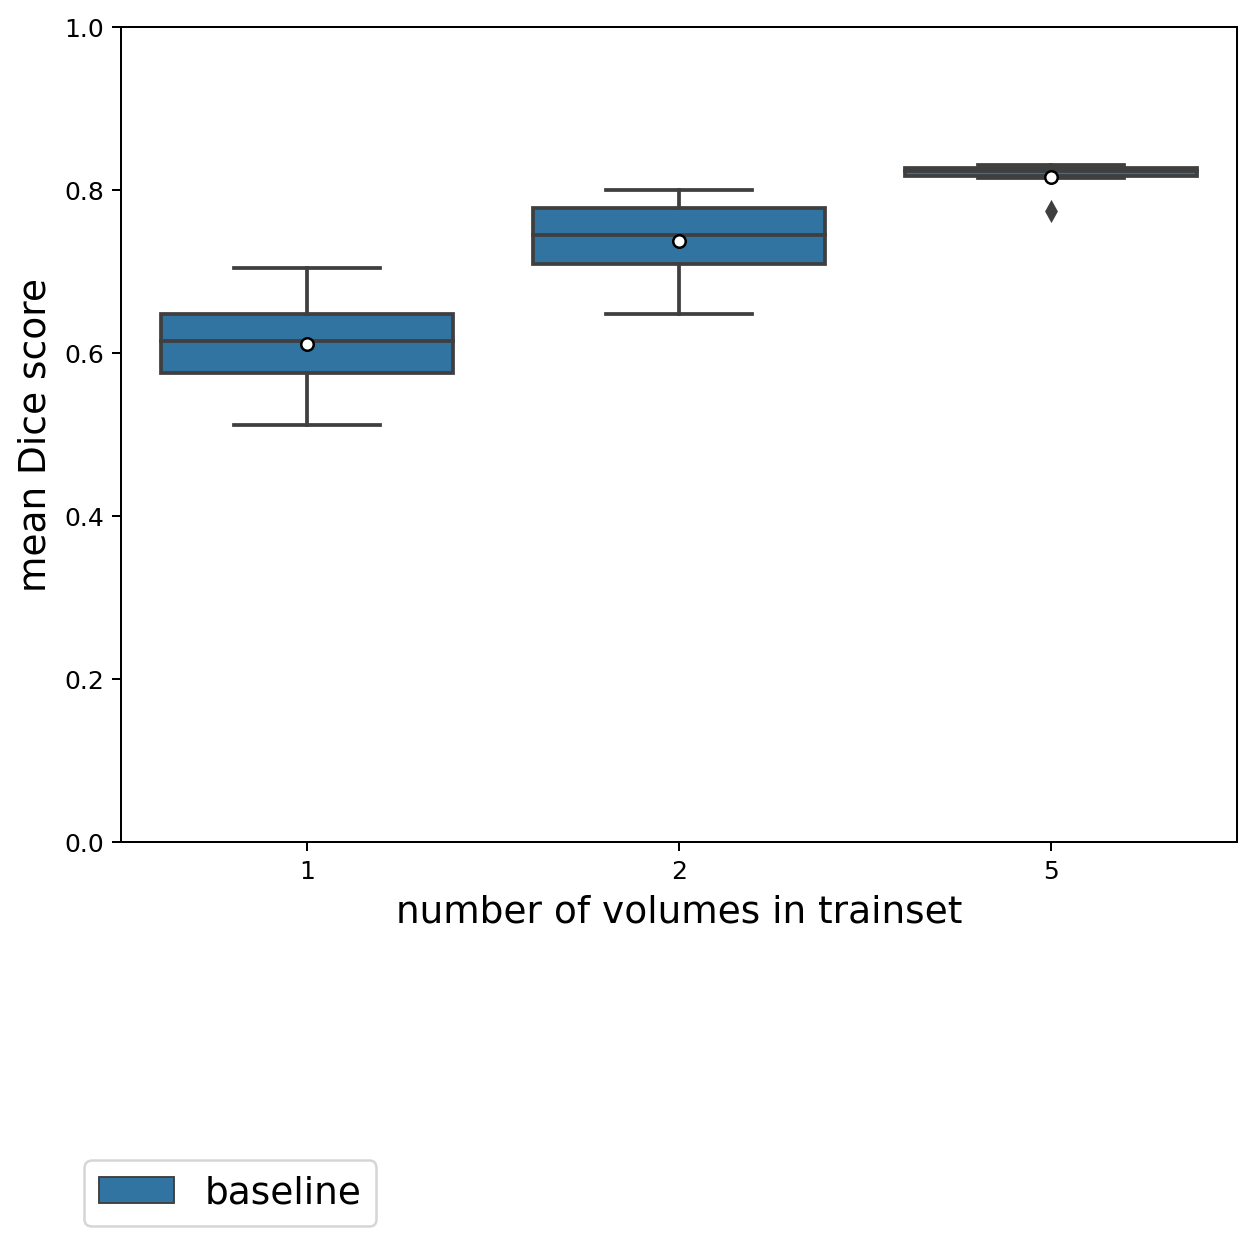

In [10]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline', 
               ]
runs = ['0', '1', '2', '3', '4', '5']
n_trains = [1,2,5]
batch_sizes  = [16]
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC', plot_loss = False)
plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC', plot_loss = False)
results_test_f1

mean  \
n vol train model                                                          
1           baseline                                            0.611438   
            pretrained with ACDC (global_dminus)                0.651760   
            pretrained with MMWHS-ACDC (global_dminus)          0.679981   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.625516   
2           baseline                                            0.737535   
            pretrained with ACDC (global_dminus)                0.773545   
            pretrained with MMWHS-ACDC (global_dminus)          0.775992   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.777564   
5           baseline                                            0.815617   
            pretrained with ACDC (global_dminus)                0.833403   
            pretrained with MMWHS-ACDC (global_dminus)          0.827929   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.842864   

                                                                double_std  \
n vol train model                                                            
1           baseline                                              0.122751   
            pretrained with ACDC (global_dminus)                  0.089608   
            pretrained with MMWHS-ACDC (global_dminus)            0.089532   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...    0.092729   
2           baseline                                              0.102677   
            pretrained with ACDC (global_dminus)                  0.064339   
            pretrained with MMWHS-ACDC (global_dminus)            0.059838   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...    0.045965   
5           baseline                                              0.038412   
            pretrained with ACDC (global_dminus)                  0.051059   
            pretrained with MMWHS-ACDC (global_dminus)            0.039126   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...    0.019492   

                                                                     sem  \
n vol train model                                                          
1           baseline                                            0.027448   
            pretrained with ACDC (global_dminus)                0.020037   
            pretrained with MMWHS-ACDC (global_dminus)          0.020020   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.020735   
2           baseline                                            0.022959   
            pretrained with ACDC (global_dminus)                0.014387   
            pretrained with MMWHS-ACDC (global_dminus)          0.013380   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.010278   
5           baseline                                            0.008589   
            pretrained with ACDC (global_dminus)                0.011417   
            pretrained with MMWHS-ACDC (global_dminus)          0.008749   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.004359   

                                                                 p value  
n vol train model                                                         
1           baseline                                            0.000000  
            pretrained with ACDC (global_dminus)                0.131419  
            pretrained with MMWHS-ACDC (global_dminus)          0.035636  
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.345492  
2           baseline                                            0.000000  
            pretrained with ACDC (global_dminus)                0.106678  
            pretrained with MMWHS-ACDC (global_dminus)          0.089225  
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.071313  
5           baseline                                            0.000000  
            pretrain

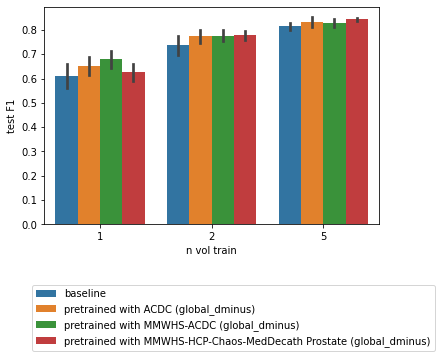

<Figure size 432x288 with 0 Axes>

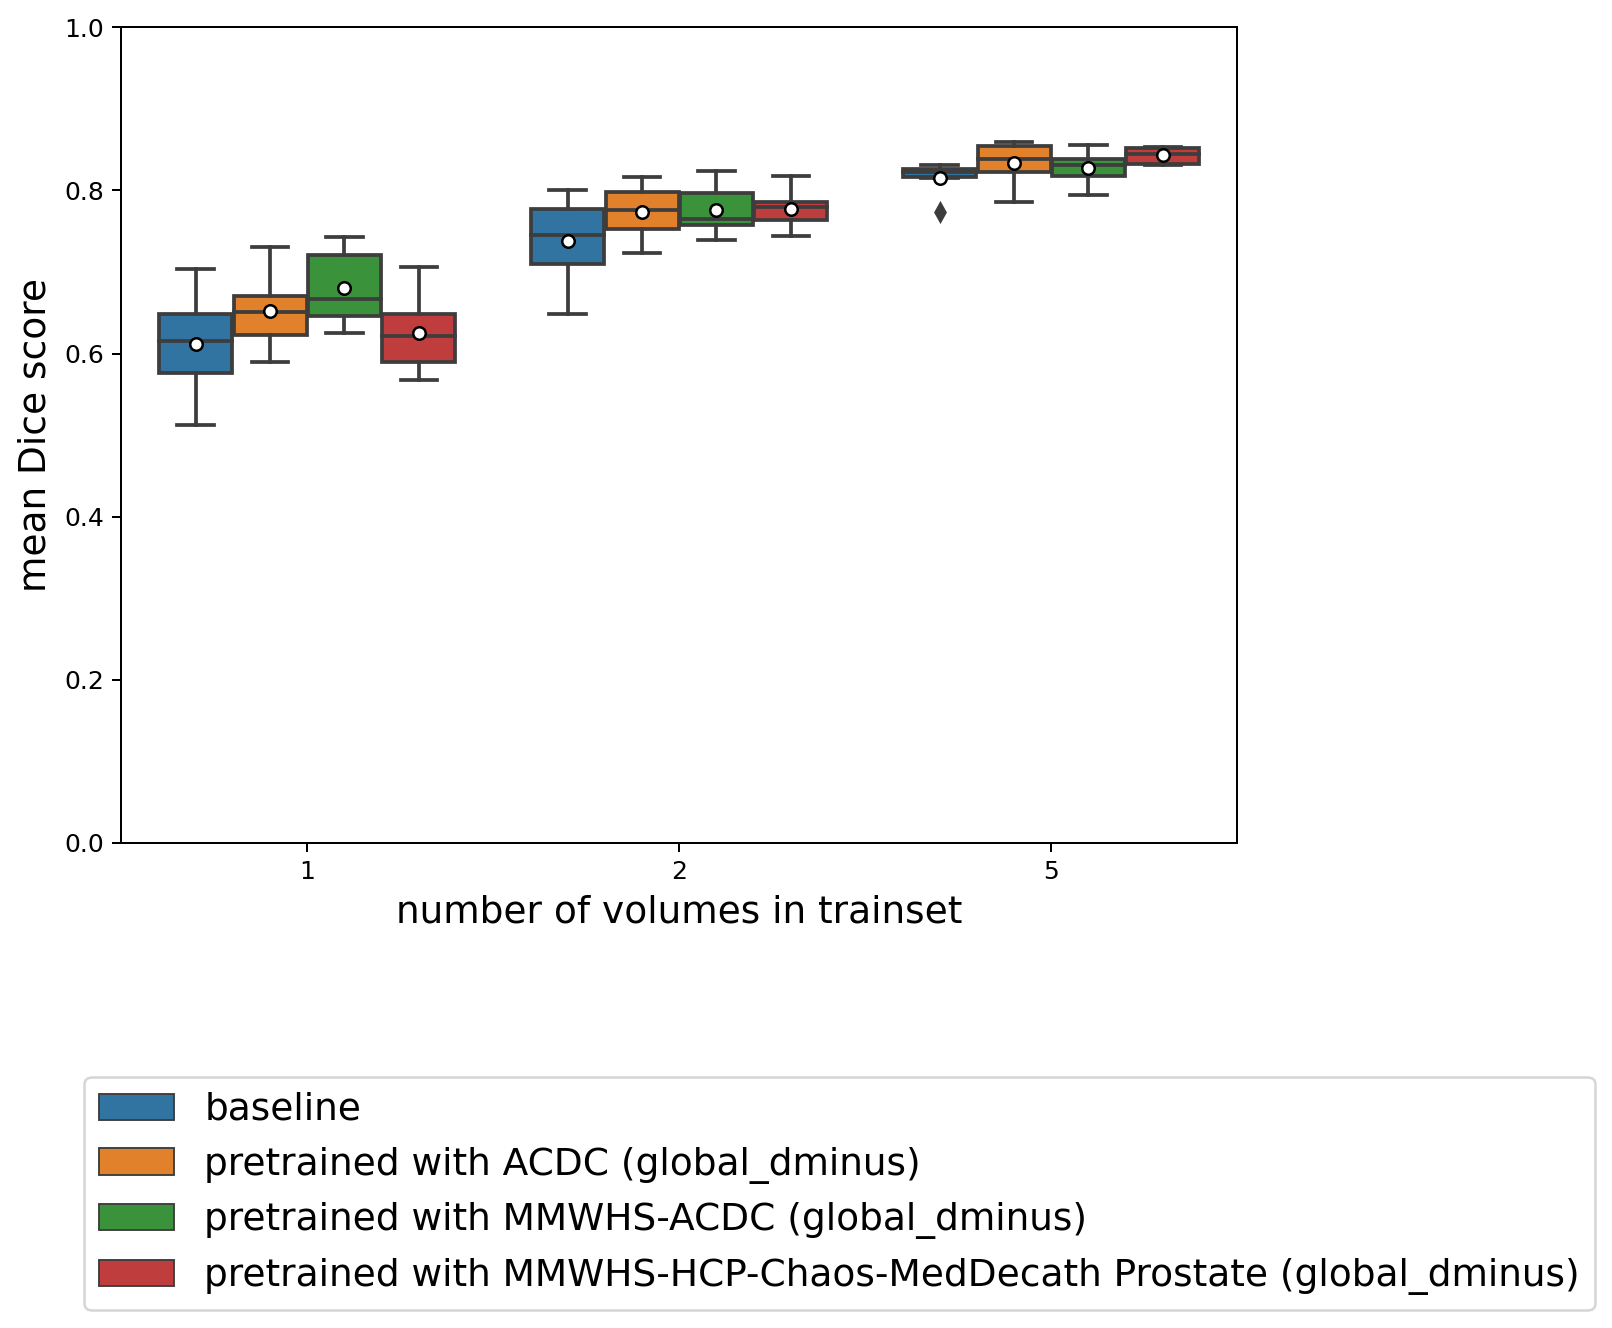

In [19]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline', 
#                'pretrained with ACDC (global_d)',
               'pretrained with ACDC (global_dminus)',
               
#                'pretrained with CIMAS (global_d)',
#                'pretrained with CIMAS (global_dminus)',
#                'pretrained with MMWHS (global_d)',
#                 'pretrained with MMWHS (global_dminus)',
               
                
#                 'pretrained with ACDC-CIMAS (global_d)',
#                 'pretrained with ACDC-CIMAS (global_dminus)',
                
#                'pretrained with MMWHS-ACDC (global_d)',
               'pretrained with MMWHS-ACDC (global_dminus)',
                
                                
#                'pretrained with MMWHS-ACDC-CIMAS (global_d)',
#                'pretrained with MMWHS-ACDC-CIMAS (global_dminus)',
#                'pretrained with CIMAS-MMWHS (global_d)',
#                'pretrained with CIMAS-MMWHS (global_dminus)',

                
#                 'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_d)',
#                 'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_dminus)',
#                 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_d)',
                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)',
               ]
runs = ['0', '1', '2', '3', '4', '5']
n_trains = [1,2,5]
batch_sizes  = [16]
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_2vol', plot_loss = False)
plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_boxplots_best', plot_loss = False)
results_test_f1#.loc[results_test_f1['p value'] < 0.05]

mean  \
n vol train batch_size model                                                          
1           16.0       baseline                                            0.611438   
                       pretrained with MMWHS-ACDC (global_dminus)          0.679981   
2           16.0       baseline                                            0.737535   
5           16.0       baseline                                            0.815617   
                       pretrained with ACDC-CIMAS (global_d)               0.843212   
                       pretrained with ACDC-CIMAS (global_dminus)          0.843318   
                       pretrained with MMWHS-ACDC (global_d)               0.844527   
                       pretrained with MMWHS-ACDC-CIMAS (global_d)         0.833233   
                       pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.842864   

                                                                           double_std  \
n vol train batch_size model                                                            
1           16.0       baseline                                              0.122751   
                       pretrained with MMWHS-ACDC (global_dminus)            0.089532   
2           16.0       baseline                                              0.102677   
5           16.0       baseline                                              0.038412   
                       pretrained with ACDC-CIMAS (global_d)                 0.020564   
                       pretrained with ACDC-CIMAS (global_dminus)            0.026980   
                       pretrained with MMWHS-ACDC (global_d)                 0.029317   
                       pretrained with MMWHS-ACDC-CIMAS (global_d)           0.014634   
                       pretrained with MMWHS-HCP-Chaos-MedDecath Prost...    0.019492   

                                                                                sem  \
n vol train batch_size model                                                          
1           16.0       baseline                                            0.027448   
                       pretrained with MMWHS-ACDC (global_dminus)          0.020020   
2           16.0       baseline                                            0.022959   
5           16.0       baseline                                            0.008589   
                       pretrained with ACDC-CIMAS (global_d)               0.004598   
                       pretrained with ACDC-CIMAS (global_dminus)          0.006033   
                       pretrained with MMWHS-ACDC (global_d)               0.006555   
                       pretrained with MMWHS-ACDC-CIMAS (global_d)         0.003272   
                       pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.004359   

                                                                            p value  
n vol train batch_size model                                                         
1           16.0       baseline                                            0.000000  
                       pretrained with MMWHS-ACDC (global_dminus)          0.035636  
2           16.0       baseline                                            0.000000  
5           16.0       baseline                                            0.000000  
                       pretrained with ACDC-CIMAS (global_d)               0.008888  
                       pretrained with ACDC-CIMAS (global_dminus)          0.012386  
                       pretrained with MMWHS-ACDC (global_d)               0.011634  
                       pretrained with MMWHS-ACDC-CIMAS (global_d)         0.042143  
                       pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.008944

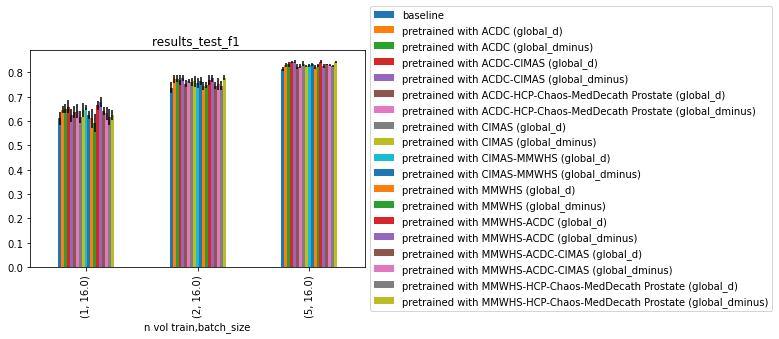

<Figure size 432x288 with 0 Axes>

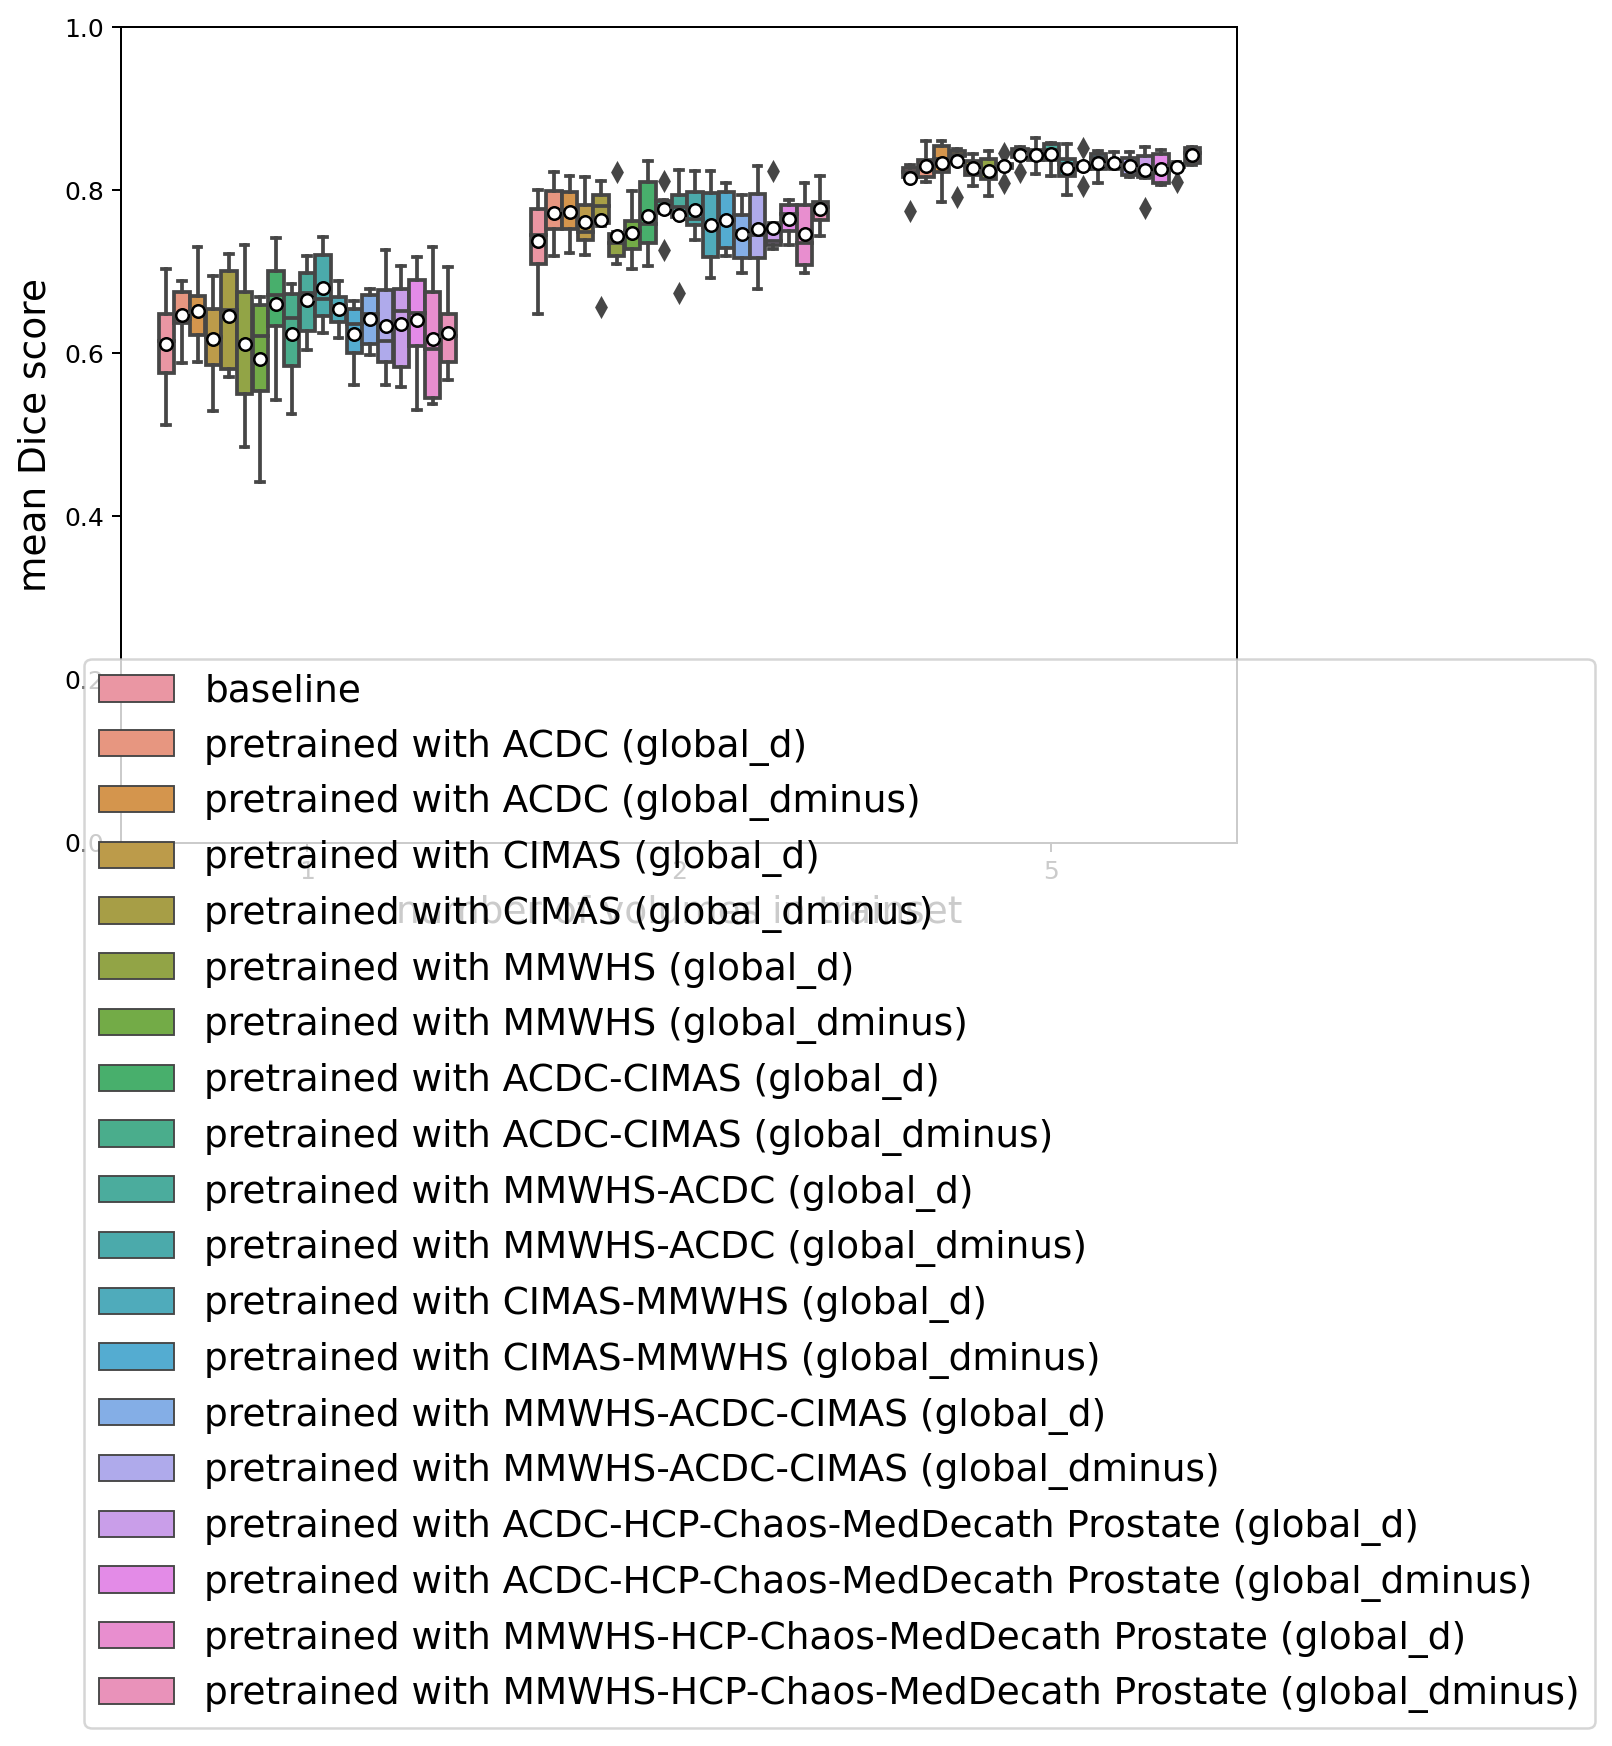

In [135]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline', 
               'pretrained with ACDC (global_d)',
               'pretrained with ACDC (global_dminus)',
               
               'pretrained with CIMAS (global_d)',
               'pretrained with CIMAS (global_dminus)',
               'pretrained with MMWHS (global_d)',
                'pretrained with MMWHS (global_dminus)',
               
                
                'pretrained with ACDC-CIMAS (global_d)',
                'pretrained with ACDC-CIMAS (global_dminus)',
                
               'pretrained with MMWHS-ACDC (global_d)',
               'pretrained with MMWHS-ACDC (global_dminus)',
                
                
               'pretrained with CIMAS-MMWHS (global_d)',
               'pretrained with CIMAS-MMWHS (global_dminus)',
                
               'pretrained with MMWHS-ACDC-CIMAS (global_d)',
               'pretrained with MMWHS-ACDC-CIMAS (global_dminus)',
                
                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_d)',
                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_dminus)',
                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_d)',
                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)',
               ]
runs = ['0', '1', '2', '3', '4', '5']
n_trains = [1,2,5]
batch_sizes  = [16]
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_1D', plot_loss = False)
plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_boxplots_2D', plot_loss = False)
results_test_f1.loc[results_test_f1['p value'] < 0.05]

here
here
['RV', 'Myo', 'LV']


n vol train  label  model   
2            LV     baseline    0.0
             Myo    baseline    0.0
             RV     baseline    0.0
Name: p value, dtype: float64

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

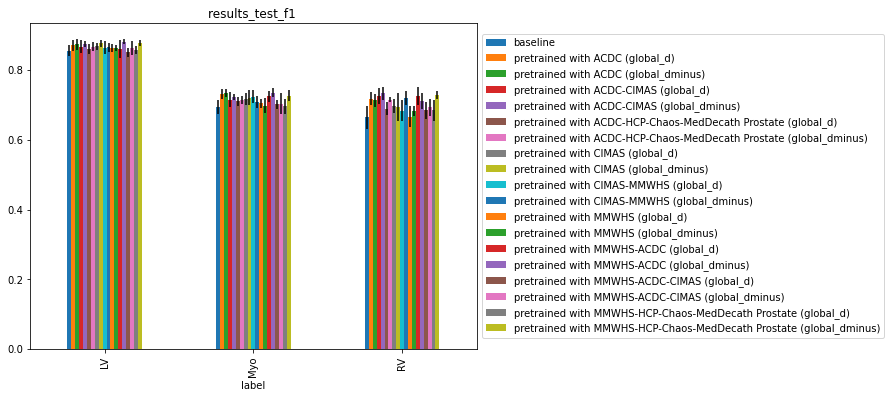

<Figure size 432x288 with 0 Axes>

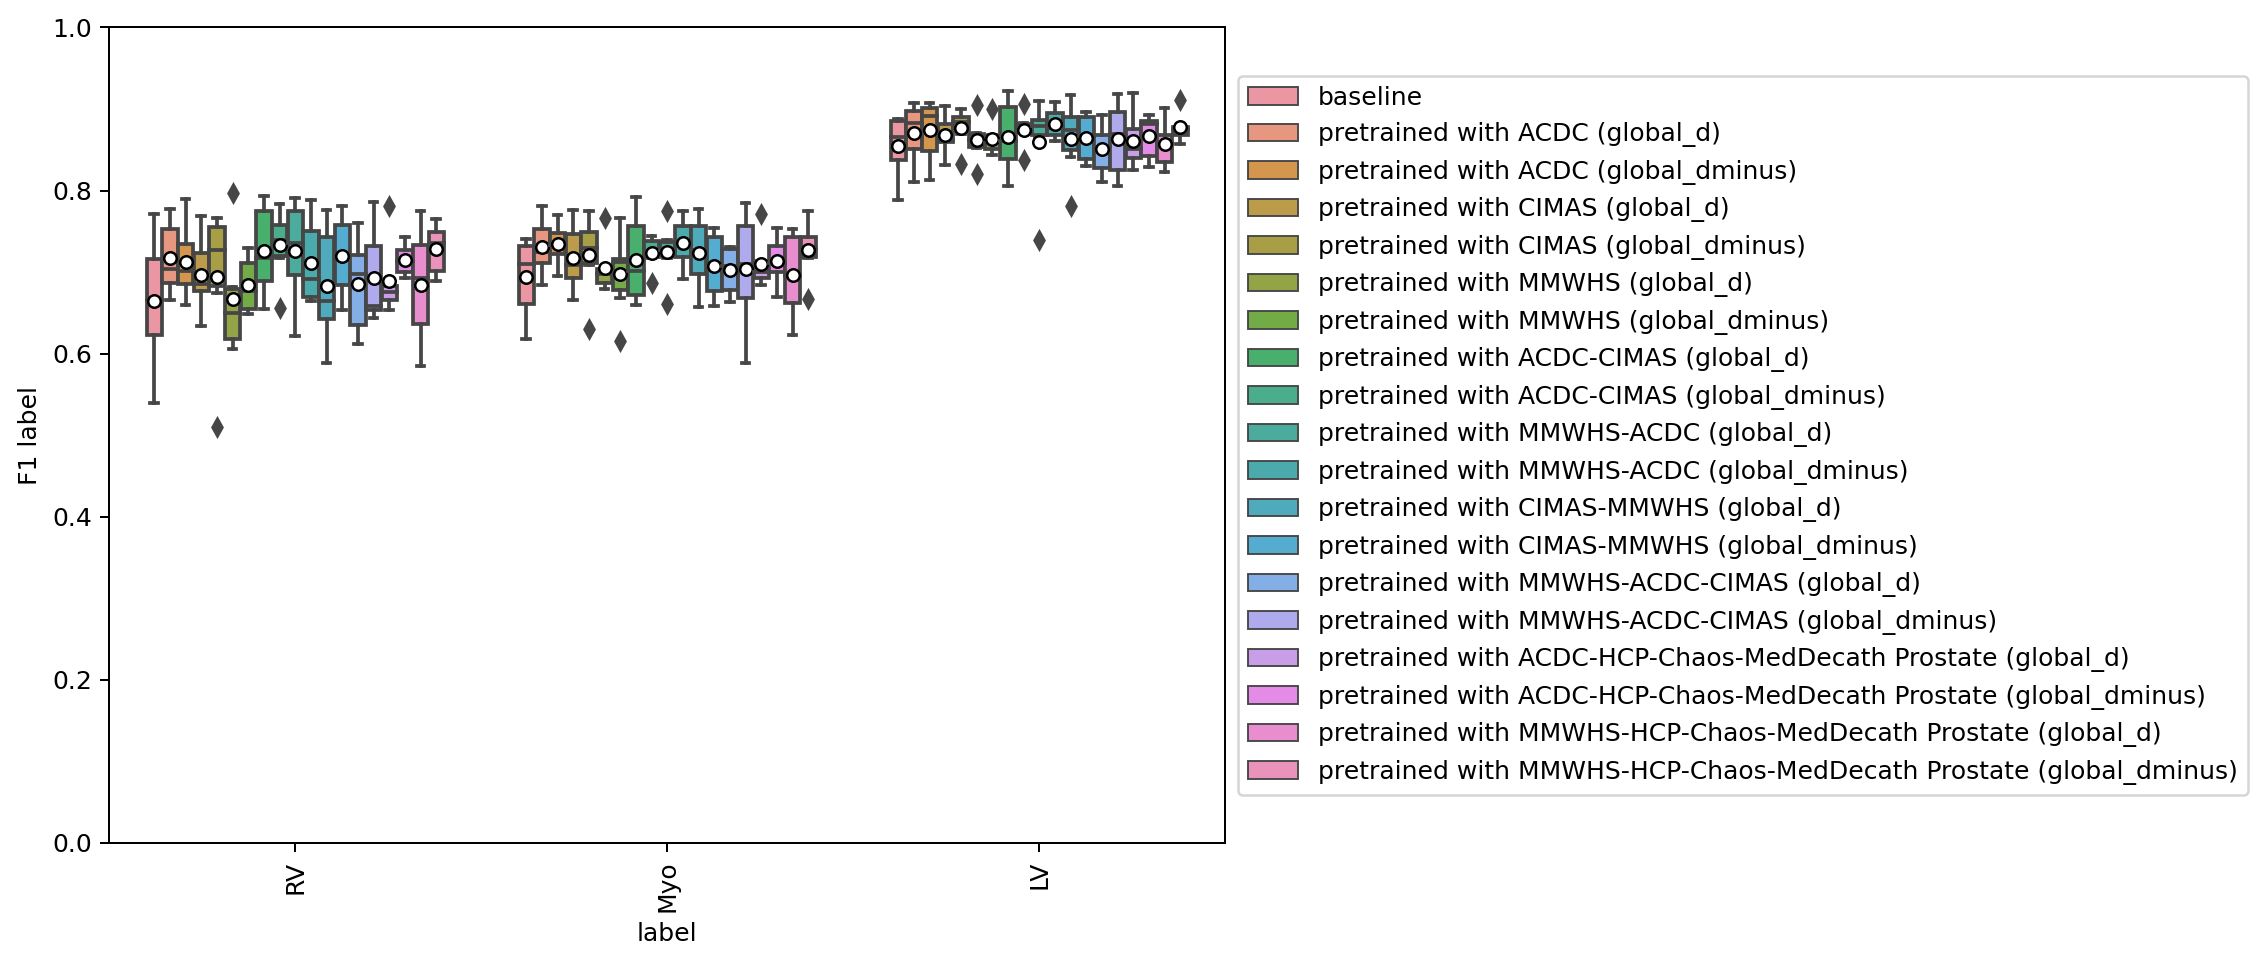

In [136]:
n_trains = [2]
results_label = plot_results_per_label(save_directory, lr, pretrainings, n_trains, 
                                       batch_sizes, losses, 'ACDC', 'ACDC_labels')
plt.figure()
results_labels, results_labels_p = boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses, 'ACDC','ACDC_labels_boxplot_2')
results_labels_p.loc[results_labels_p< 0.05]

here
here
['RV', 'Myo', 'LV']


label  model            n vol train
LV     n = 2, baseline  2              0.0
Myo    n = 2, baseline  2              0.0
RV     n = 2, baseline  2              0.0
Name: p value, dtype: float64

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

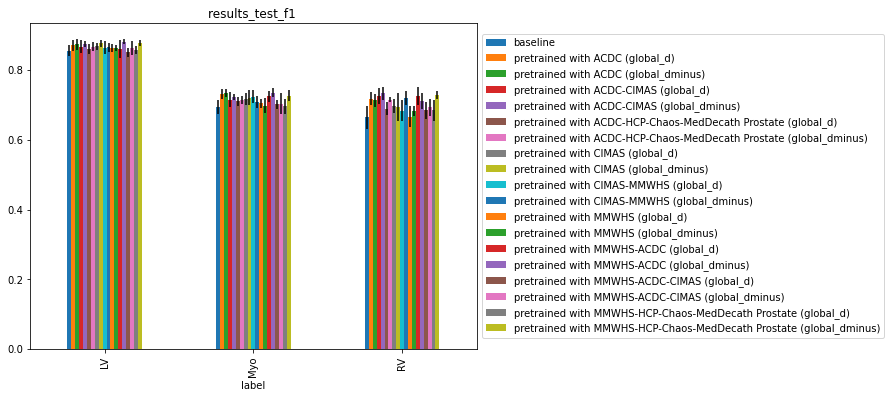

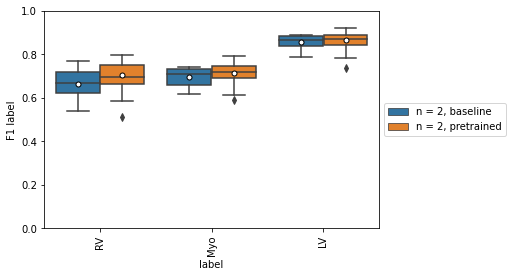

In [137]:
n_trains = [2]
results_label = plot_results_per_label(save_directory, lr, pretrainings, n_trains, 
                                       batch_sizes, losses, 'ACDC', 'ACDC_labels')
plt.figure()
results_labels, results_labels_p = boxplot_labels_mean(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses, 'ACDC','ACDC_labels_boxplot_2')
results_labels_p.loc[results_labels_p< 0.05]

In [138]:
results_labels

,model,n vol train,label,lr,loss unet,train F1,validation F1,test F1,train loss,validation loss,test loss,best epoch,batch_size,f1_arr,F1 label,p value
0,"n = 2, baseline",2,RV,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.930455,0.843048,0.724182,0.029666,0.066774,0.180870,1087,16.0,"[0.6381846679397607, 0.7005764907733081, 0.833...",0.638185,0.000000
0,"n = 2, baseline",2,Myo,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.930455,0.843048,0.724182,0.029666,0.066774,0.180870,1087,16.0,"[0.6381846679397607, 0.7005764907733081, 0.833...",0.700576,0.000000
0,"n = 2, baseline",2,LV,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.930455,0.843048,0.724182,0.029666,0.066774,0.180870,1087,16.0,"[0.6381846679397607, 0.7005764907733081, 0.833...",0.833785,0.000000
0,"n = 2, baseline",2,RV,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.930725,0.299246,0.648514,0.042325,0.250744,0.262227,553,16.0,"[0.5389919021695331, 0.617620504280034, 0.7889...",0.538992,0.000000
0,"n = 2, baseline",2,Myo,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.930725,0.299246,0.648514,0.042325,0.250744,0.262227,553,16.0,"[0.5389919021695331, 0.617620504280034, 0.7889...",0.617621,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"n = 2, pretrained",2,Myo,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.926812,0.725176,0.776489,0.032662,0.065699,0.159667,847,16.0,"[0.7494227516678713, 0.7224826094493311, 0.857...",0.722483,0.110139
0,"n = 2, pretrained",2,LV,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.926812,0.725176,0.776489,0.032662,0.065699,0.159667,847,16.0,"[0.7494227516678713, 0.7224826094493311, 0.857...",0.857560,0.112001
0,"n = 2, pretrained",2,RV,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.946676,0.584363,0.781806,0.023397,0.080952,0.180883,1217,16.0,"[0.7226049716558465, 0.7452738027500118, 0.877...",0.722605,0.053300
0,"n = 2, pretrained",2,Myo,"0 0.001 Name: lr, dtype: float64",crossentropy_loss,0.946676,0.584363,0.781806,0.023397,0.080952,0.180883,1217,16.0,"[0.7226049716558465, 0.7452738027500118, 0.877...",0.745274,0.110139


In [139]:
results_label.xs('baseline', level = 1)

,mean,double_std,sem
label,,,
LV,0.854660,0.071432,0.015973
Myo,0.693910,0.091924,0.020555
RV,0.664035,0.151581,0.033895


In [140]:
results_label[results_label.index.get_level_values(1) != 'baseline'].mean(level = 0)

,mean,double_std,sem
label,,,
LV,0.866611,0.059500,0.013305
Myo,0.715980,0.073086,0.016342
RV,0.703586,0.099249,0.022193


In [141]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].mean(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,0.011951,-0.011932,-0.002668
Myo,0.022070,-0.018838,-0.004212
RV,0.039551,-0.052332,-0.011702


In [142]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].max(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,0.026727,0.040061,0.008958
Myo,0.041341,0.040872,0.009139
RV,0.068733,0.024502,0.005479


In [143]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].min(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,-0.004145,-0.037755,-0.008442
Myo,0.002258,-0.053618,-0.011989
RV,0.002642,-0.115758,-0.025884


# CIMAS

mean  \
n vol train model                                                          
1           baseline                                            0.768358   
            pretrained with ACDC-CIMAS (global_d)               0.794476   
            pretrained with CIMAS (global_d)                    0.789188   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.777150   
2           baseline                                            0.788142   
            pretrained with ACDC-CIMAS (global_d)               0.824399   
            pretrained with CIMAS (global_d)                    0.832312   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.806961   
5           baseline                                            0.837867   
            pretrained with ACDC-CIMAS (global_d)               0.850071   
            pretrained with CIMAS (global_d)                    0.851348   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.844008   

                                                                double_std  \
n vol train model                                                            
1           baseline                                              0.096383   
            pretrained with ACDC-CIMAS (global_d)                 0.073715   
            pretrained with CIMAS (global_d)                      0.078513   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...    0.086559   
2           baseline                                              0.127619   
            pretrained with ACDC-CIMAS (global_d)                 0.039480   
            pretrained with CIMAS (global_d)                      0.037574   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...    0.063317   
5           baseline                                              0.037013   
            pretrained with ACDC-CIMAS (global_d)                 0.036656   
            pretrained with CIMAS (global_d)                      0.022468   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...    0.030196   

                                                                     sem  \
n vol train model                                                          
1           baseline                                            0.021552   
            pretrained with ACDC-CIMAS (global_d)               0.016483   
            pretrained with CIMAS (global_d)                    0.017556   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.019355   
2           baseline                                            0.028537   
            pretrained with ACDC-CIMAS (global_d)               0.008828   
            pretrained with CIMAS (global_d)                    0.008402   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.014158   
5           baseline                                            0.008276   
            pretrained with ACDC-CIMAS (global_d)               0.008196   
            pretrained with CIMAS (global_d)                    0.005024   
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.006752   

                                                                 p value  
n vol train model                                                         
1           baseline                                            0.000000  
            pretrained with ACDC-CIMAS (global_d)               0.179225  
            pretrained with CIMAS (global_d)                    0.235457  
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.383853  
2           baseline                                            0.000000  
            pretrained with ACDC-CIMAS (global_d)               0.126357  
            pretrained with CIMAS (global_d)                    0.084207  
            pretrained with CIMAS-HCP-Chaos-MedDecath Prost...  0.283902  
5           baseline                                            0.000000  
            pretrain

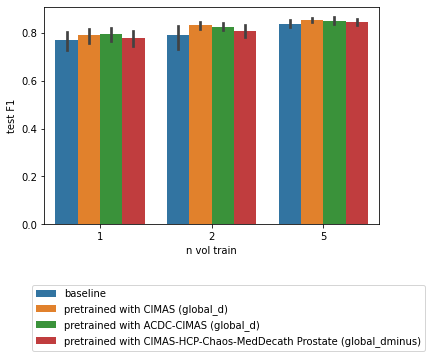

<Figure size 432x288 with 0 Axes>

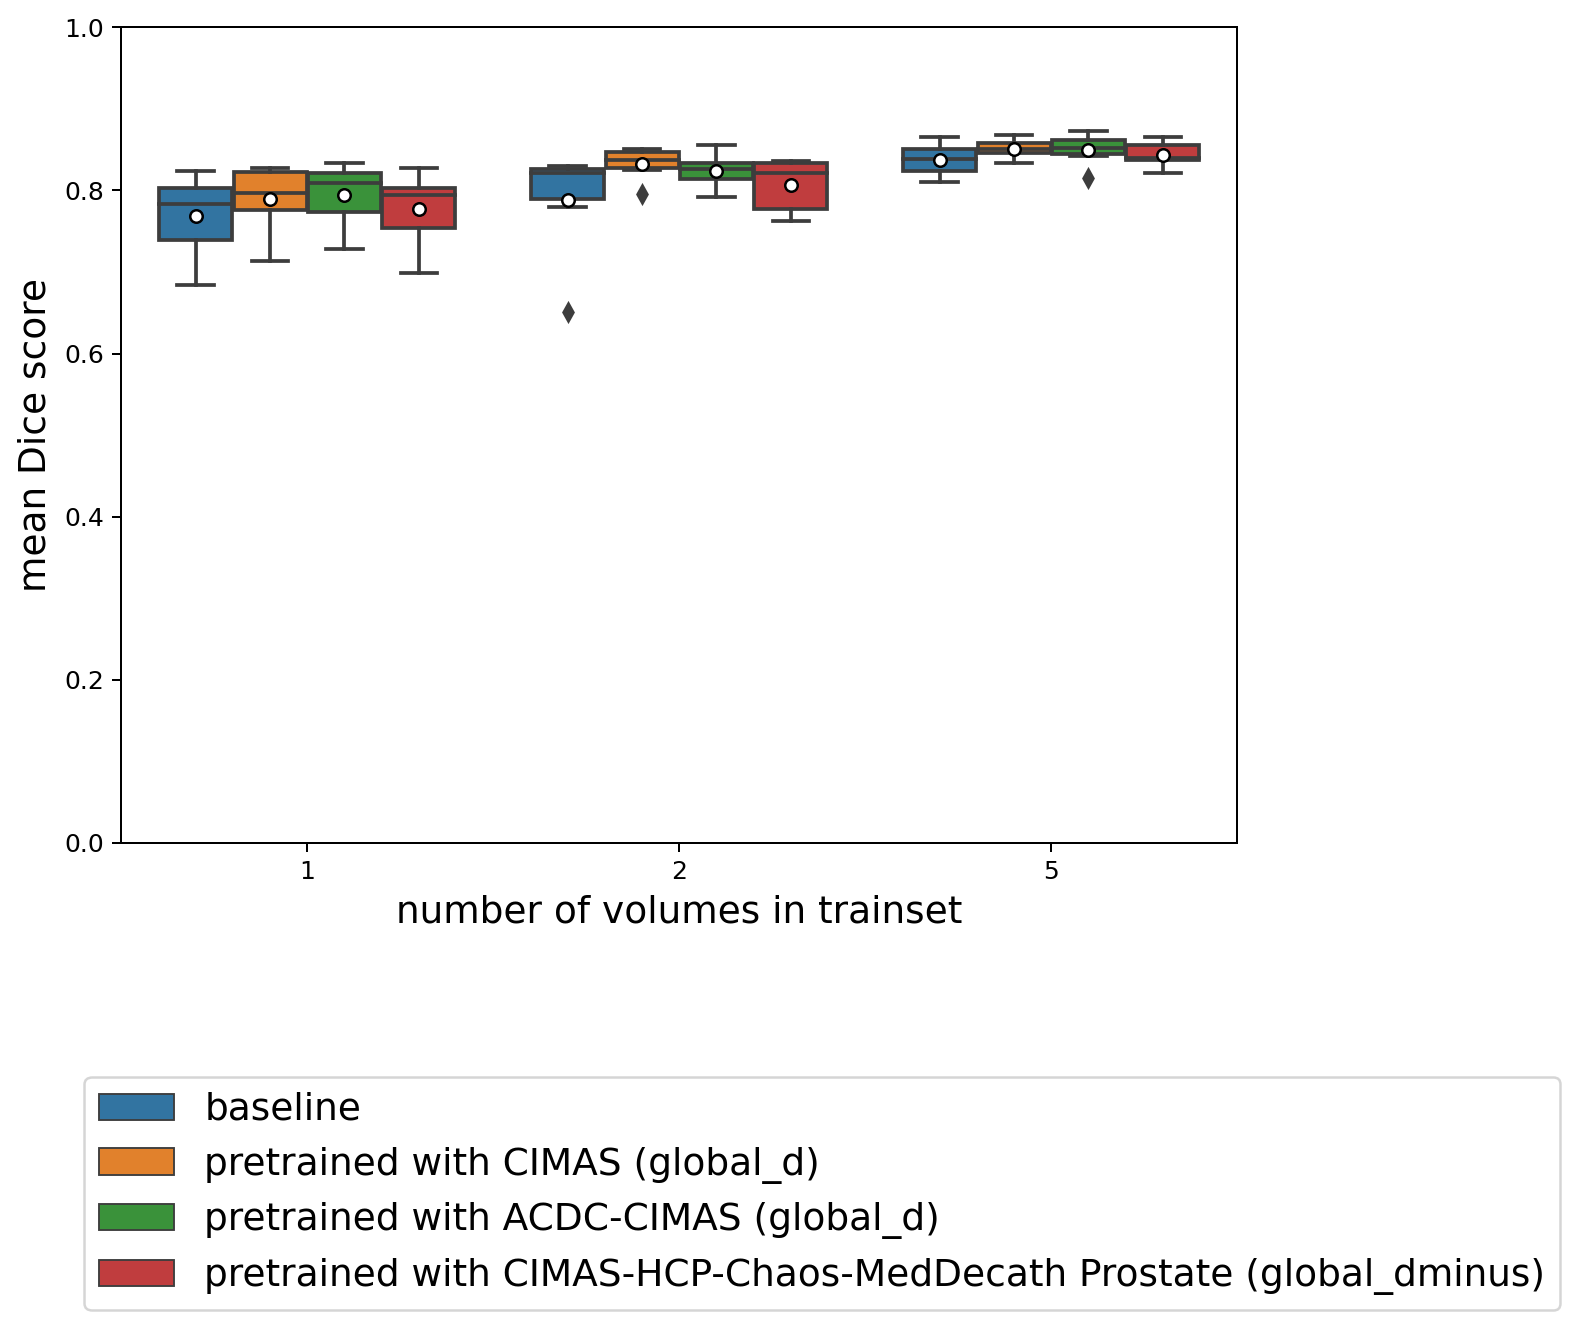

In [30]:
save_directory = './trained_models/CIMAS/'
pretrainings = ['baseline', 
               'pretrained with CIMAS (global_d)',
#                'pretrained with CIMAS (global_dminus)',
               
#                'pretrained with ACDC (global_d)',
#                'pretrained with ACDC (global_dminus)',
                
#                'pretrained with MMWHS (global_d)',
#                'pretrained with MMWHS (global_dminus)',
                
               'pretrained with ACDC-CIMAS (global_d)',
#                'pretrained with ACDC-CIMAS (global_dminus)',
#                'pretrained with CIMAS-MMWHS (global_d)',
#                'pretrained with CIMAS-MMWHS (global_dminus)',
#                'pretrained with MMWHS-ACDC-CIMAS (global_d)',
#                'pretrained with MMWHS-ACDC-CIMAS (global_dminus)',
                
#                'pretrained with MMWHS-ACDC (global_d)',
#                'pretrained with MMWHS-ACDC (global_dminus)',
               
#                'pretrained with CIMAS-HCP-Chaos-MedDecath Prostate (global_d)',
               'pretrained with CIMAS-HCP-Chaos-MedDecath Prostate (global_dminus)',
                
#                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_d)',
#                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_dminus)',
               
#                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_d)',
#                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)',
               ]
batch_sizes  = [32]
n_trains = [1,2,5]
runs = [ '0', '1', '2', '3', '4', '5']
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'CIMAS_2vol', plot_loss = False)
plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'CIMAS_boxplots_best', plot_loss = False)
results_test_f1#.loc[results_test_f1['p value'] < 0.05]

['LV', 'Myo', 'RV']


n vol train  label  model   
2            LV     baseline    0.0
             Myo    baseline    0.0
             RV     baseline    0.0
Name: p value, dtype: float64

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

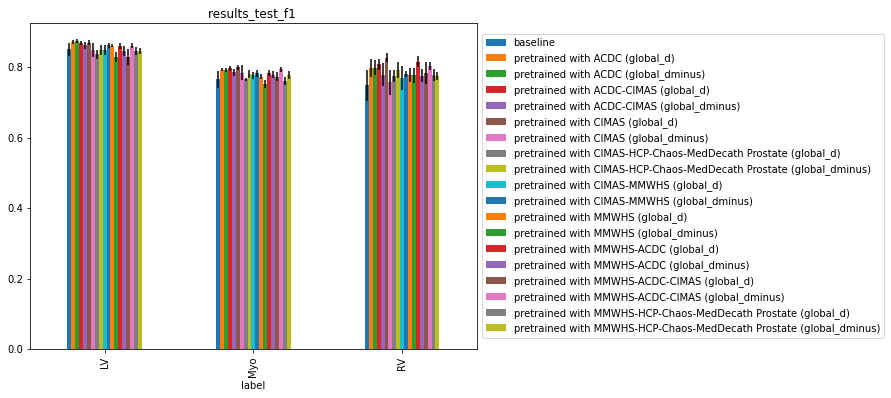

<Figure size 432x288 with 0 Axes>

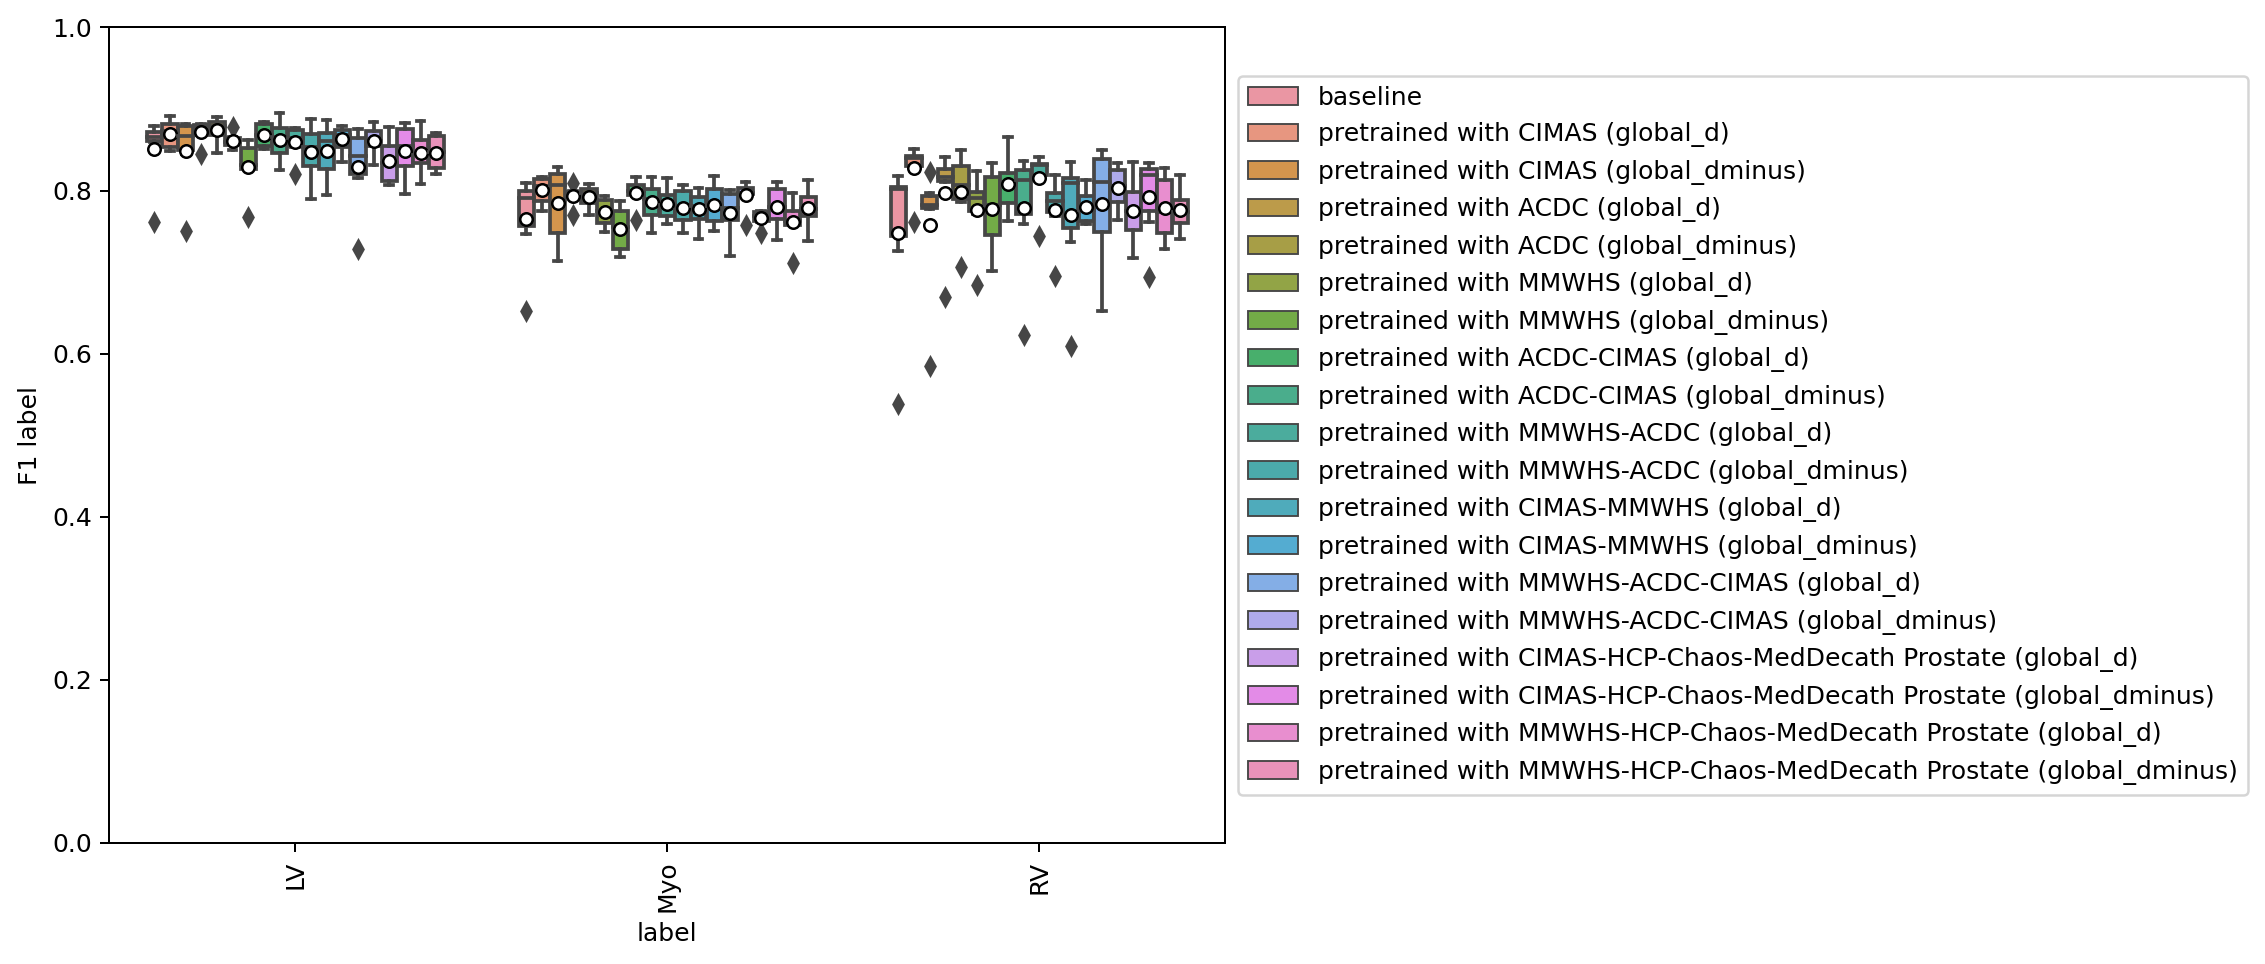

In [180]:
n_trains = [2]
results_label = plot_results_per_label(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                       losses,'CIMAS', 'ACDC_labels')
plt.figure()

results_labels, results_labels_p = boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'CIMAS','CIMAS_labels_boxplot_5')


results_labels_p.loc[results_labels_p< 0.05]

['LV', 'Myo', 'RV']


label  model            n vol train
LV     n = 2, baseline  2              0.0
Myo    n = 2, baseline  2              0.0
RV     n = 2, baseline  2              0.0
Name: p value, dtype: float64

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

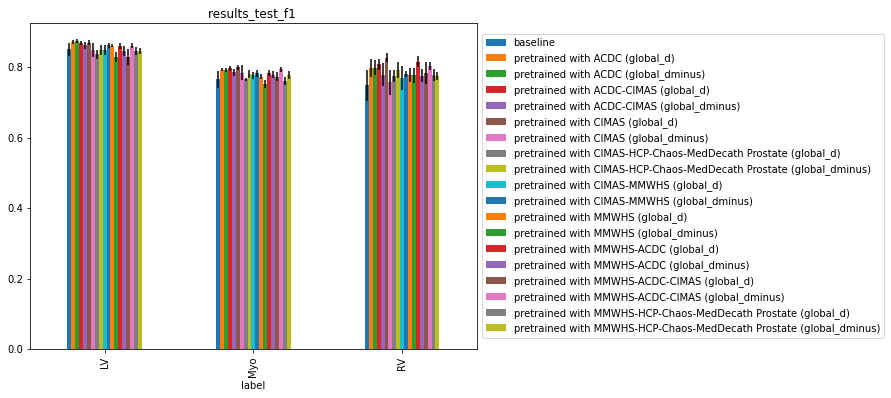

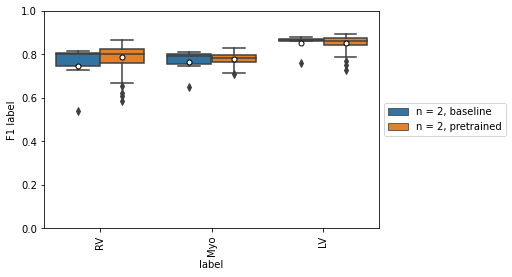

In [181]:
n_trains = [2]
results_label = plot_results_per_label(save_directory, lr, pretrainings, n_trains, 
                                       batch_sizes, losses, 'CIMAS', 'CIMAS_labels')
plt.figure()
results_labels, results_labels_p = boxplot_labels_mean(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses, 'CIMAS','CIMAS_labels_boxplot_2')
results_labels_p.loc[results_labels_p< 0.05]

In [182]:
results_label.xs('baseline', level = 1)

,mean,double_std,sem
label,,,
LV,0.850891,0.081078,0.018130
Myo,0.765191,0.108884,0.024347
RV,0.748345,0.197028,0.044057


In [183]:
results_label[results_label.index.get_level_values(1) != 'baseline'].mean(level = 0)

,mean,double_std,sem
label,,,
LV,0.853907,0.048275,0.010795
Myo,0.780792,0.042685,0.009545
RV,0.787312,0.092153,0.020606


In [184]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].mean(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,0.003016,-0.032803,-0.007335
Myo,0.015602,-0.066200,-0.014803
RV,0.038968,-0.104874,-0.023451


In [185]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].min(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,-0.022106,-0.063257,-0.014145
Myo,-0.012224,-0.090218,-0.020173
RV,0.009295,-0.157379,-0.035191


In [186]:
(results_label[results_label.index.get_level_values(1) != 'baseline'].max(level = 0) - results_label.xs('baseline', level = 1))

,mean,double_std,sem
label,,,
LV,0.023367,0.017550,0.003924
Myo,0.035249,-0.017707,-0.003959
RV,0.078764,-0.039841,-0.008909


# Abide

def boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 
                   dataset, save_file, ordered_diff=None) :
    
    results = pd.DataFrame(columns = ['model', 'n vol train', 'label'])
    
    labels = []
    if dataset == 'ACDC' :
        labels = ['RV', 'Myo', 'LV'] 
    elif dataset == 'CIMAS' :
        labels = ['LV', 'Myo', 'RV'] 
    elif dataset == 'Abide' :
        labels = ["cerebellum GM", "cerebellum WM", "cerebral GM", "cerebral WM",
                  "thalamus ", "hippocampus", "amygdala", "lateral ventricles", 
                  "caudate", "putamen", "pallidum", "ventral Diencephalon", 
                  "third ventricle", "brain stem"] 
    else :
        print('error')
        
    print(labels)
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + \
                                                str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + \
                                                '_' + str(n_train) + \
                                                '_vol_in_train_2_vol_in_val/run_' + str(run)
                        
                            
                        infile = open(save_directory_name + '/results.pkl','rb')   
                        results_BN = pickle.load(infile)
    
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            if ordered_diff is not None :
                                if label  in ordered_diff.index[0:4]:
                                    results=results.append(results_BN)
                                
                            elif ordered_diff is None :
                                results=results.append(results_BN)   
                            
    results['model'][results['model'] == 'pretrained with MMWHSC-HCP-Chaos-MedDecath Prostate (global_dminus)'] = \
                                         'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
    
    ax = sns.boxplot(x = results["label"], y = results['F1 label'], hue = results["model"],
                showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
    plt.setp(ax.get_xticklabels(), rotation=45)
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.get_legend().remove()
    plt.savefig('trained_models/figures/'+ save_file +'.png', bbox_inches='tight')
    

mean  double_std       sem  p value
n vol train batch_size model                                            
1           64.0       baseline  0.836643    0.063975  0.031987        0
            128.0      baseline  0.873074    0.016757  0.008378        0
2           64.0       baseline  0.871933    0.009677  0.004839        0
            128.0      baseline  0.876624    0.000723  0.000362        0
5           64.0       baseline  0.878294    0.013457  0.006728        0
            128.0      baseline  0.890850    0.004164  0.002082        0

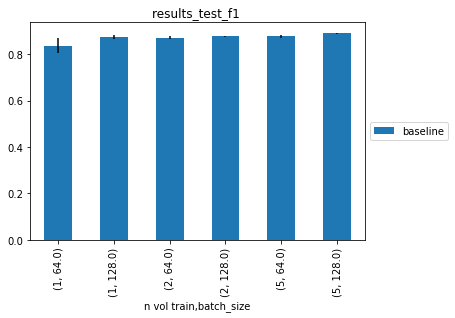

In [22]:
lr = 0.001
losses = ['crossentropy_loss']
save_directory = './trained_models/Abide/'
pretrainings = ['baseline']
batch_sizes  = [64,128]
runs = ['0', '1']#
n_trains = [1, 2, 5]
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_results_f1', plot_loss =False)

results_test_f1

mean  \
n vol train model                                                          
1           baseline                                            0.848191   
2           baseline                                            0.853610   
            pretrained with ACDC-Abide-Chaos-MedDecath Pros...  0.880660   
            pretrained with Abide-HCP-USZ (global_d)            0.875177   
5           baseline                                            0.859603   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...  0.882510   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...  0.887351   
            pretrained with Abide (global_dminus)               0.886447   
            pretrained with Abide-HCP-USZ (global_d)            0.881236   
            pretrained with Abide-HCP-USZ (global_dminus)       0.879678   
            pretrained with HCP-Abide (global_dminus)           0.885968   
            pretrained with HCP-USZ (global_d)                  0.883554   
            pretrained with HCP-USZ (global_dminus)             0.880884   

                                                                double_std  \
n vol train model                                                            
1           baseline                                              0.065797   
2           baseline                                              0.041107   
            pretrained with ACDC-Abide-Chaos-MedDecath Pros...    0.012451   
            pretrained with Abide-HCP-USZ (global_d)              0.015354   
5           baseline                                              0.043832   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...    0.013548   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...    0.012043   
            pretrained with Abide (global_dminus)                 0.004418   
            pretrained with Abide-HCP-USZ (global_d)              0.018089   
            pretrained with Abide-HCP-USZ (global_dminus)         0.022316   
            pretrained with HCP-Abide (global_dminus)             0.008502   
            pretrained with HCP-USZ (global_d)                    0.008537   
            pretrained with HCP-USZ (global_dminus)               0.012586   

                                                                     sem  \
n vol train model                                                          
1           baseline                                            0.014713   
2           baseline                                            0.009192   
            pretrained with ACDC-Abide-Chaos-MedDecath Pros...  0.002784   
            pretrained with Abide-HCP-USZ (global_d)            0.003433   
5           baseline                                            0.009801   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...  0.003030   
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...  0.002693   
            pretrained with Abide (global_dminus)               0.000988   
            pretrained with Abide-HCP-USZ (global_d)            0.004045   
            pretrained with Abide-HCP-USZ (global_dminus)       0.004990   
            pretrained with HCP-Abide (global_dminus)           0.001901   
            pretrained with HCP-USZ (global_d)                  0.001909   
            pretrained with HCP-USZ (global_dminus)             0.002814   

                                                                 p value  
n vol train model                                                         
1           baseline                                            0.000000  
2           baseline                                            0.000000  
            pretrained with ACDC-Abide-Chaos-MedDecath Pros...  0.009135  
            pretrained with Abide-HCP-USZ (global_d)            0.026306  
5           baseline                                            0.000000  
            pretrained with ACDC-HCP-Chaos-MedDecath Prosta...  0.024798  
            pre

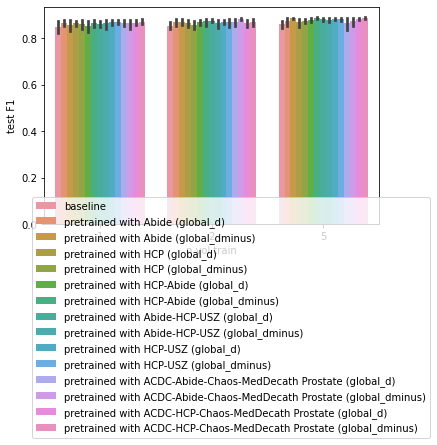

<Figure size 432x288 with 0 Axes>

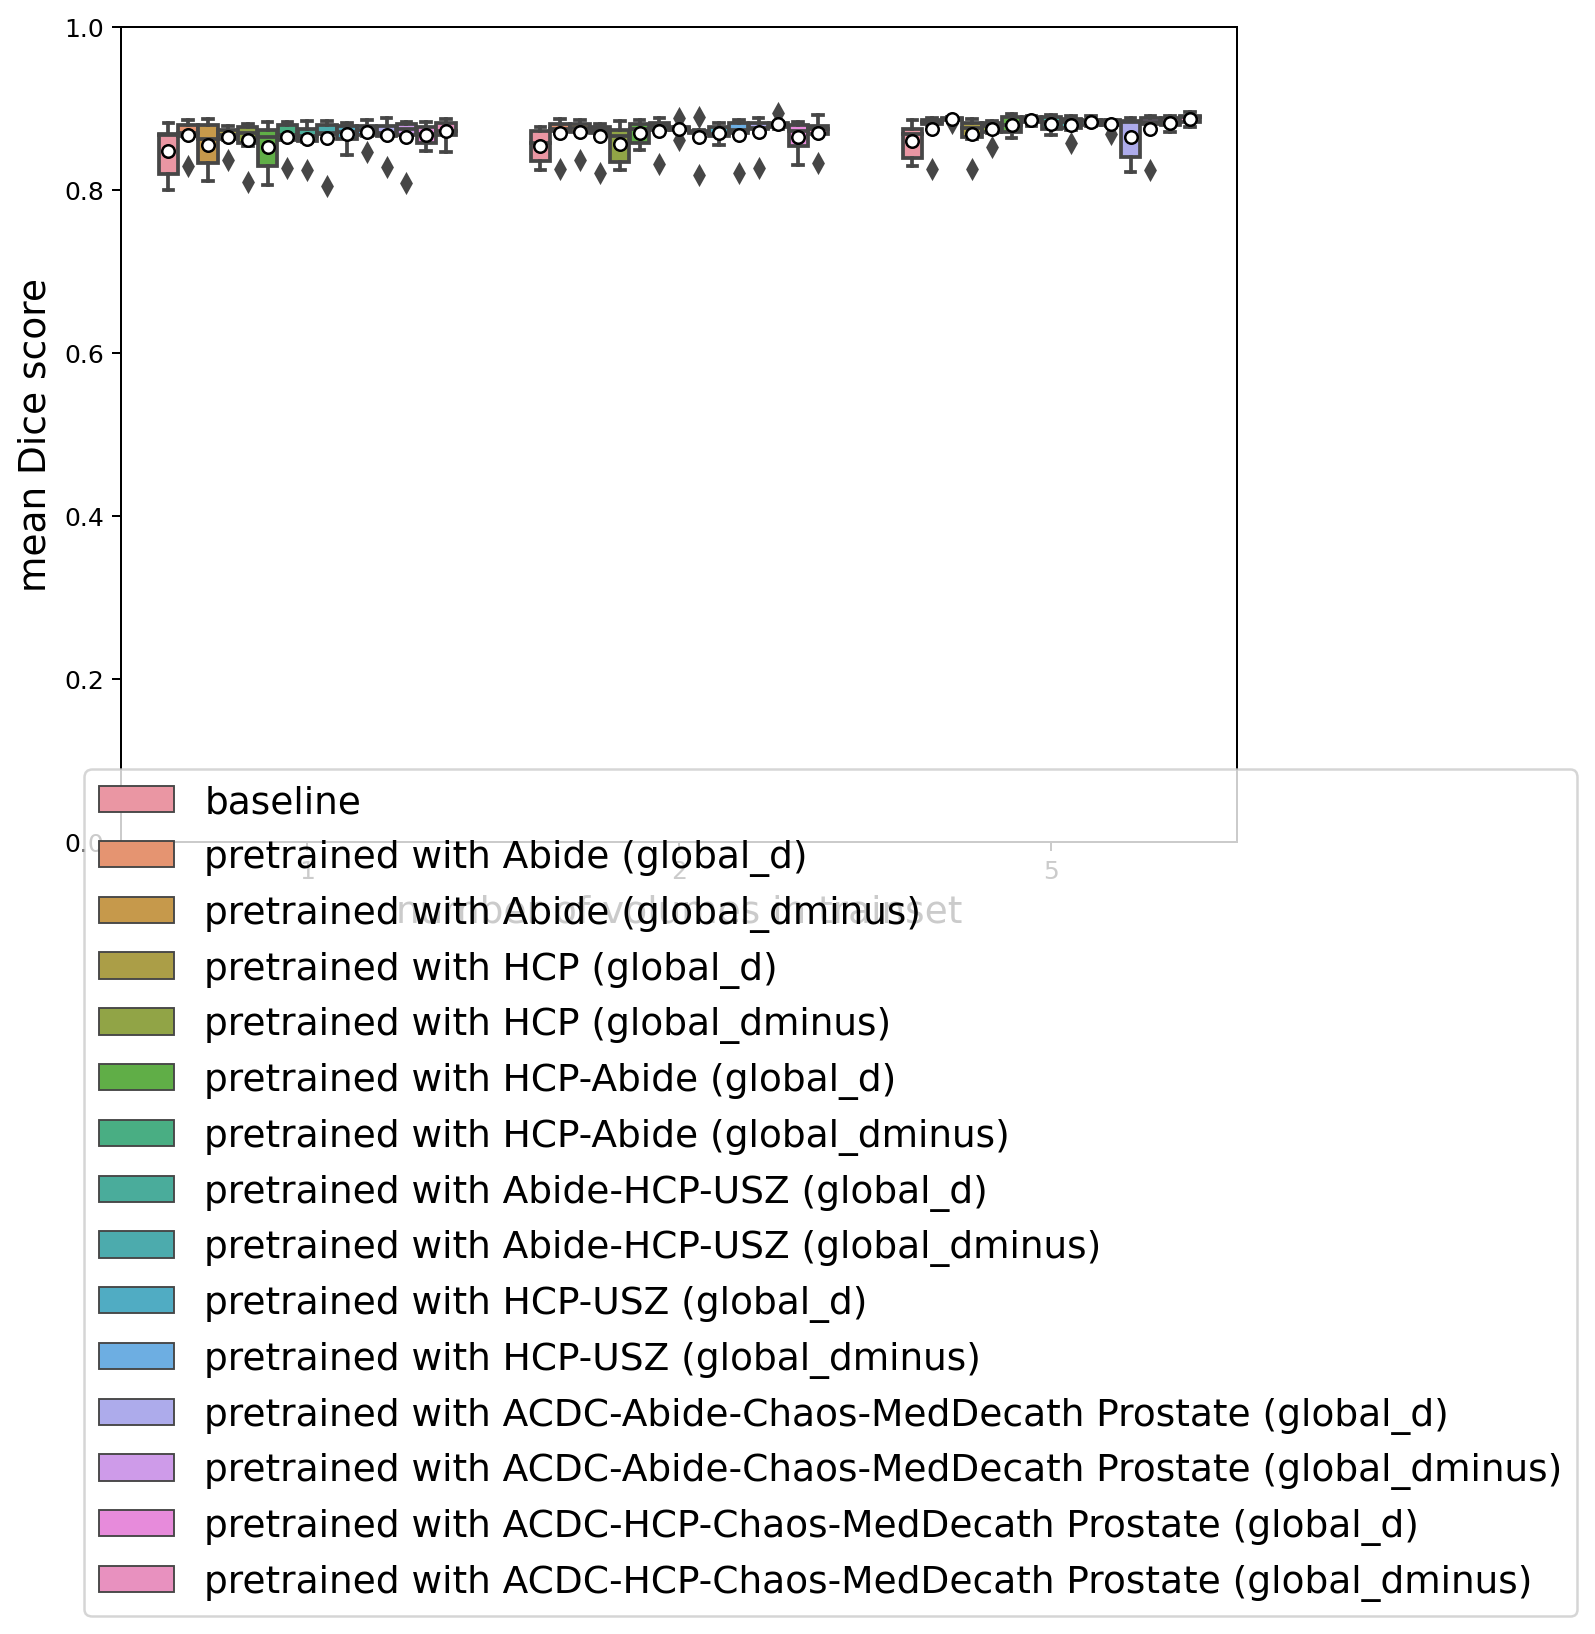

In [129]:
lr = 0.001
losses = ['crossentropy_loss']
save_directory = './trained_models/Abide/'
pretrainings = ['baseline',
                 'pretrained with Abide (global_d)',
                'pretrained with Abide (global_dminus)',
                
                'pretrained with HCP (global_d)',
                'pretrained with HCP (global_dminus)',
                'pretrained with HCP-Abide (global_d)',
                'pretrained with HCP-Abide (global_dminus)',
                'pretrained with Abide-HCP-USZ (global_d)',
                'pretrained with Abide-HCP-USZ (global_dminus)',
                'pretrained with HCP-USZ (global_d)',
                'pretrained with HCP-USZ (global_dminus)',
                'pretrained with ACDC-Abide-Chaos-MedDecath Prostate (global_d)',
                'pretrained with ACDC-Abide-Chaos-MedDecath Prostate (global_dminus)',
                
                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_d)',
                'pretrained with ACDC-HCP-Chaos-MedDecath Prostate (global_dminus)'
                
#                 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_d)',
#                 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)',
               ]
runs = ['0', '1', '2', '3','4',  '5'] 
batch_sizes  = [64]
n_trains = [1,2,5]
plt.figure()
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_2vol', plot_loss = False)
plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_boxplots_best', plot_loss = False)
results_test_f1.loc[results_test_f1['p value'] < 0.05]

['cerebellum GM', 'cerebellum WM', 'cerebral GM', 'cerebral WM', 'thalamus ', 'hippocampus', 'amygdala', 'lateral ventricles', 'caudate', 'putamen', 'pallidum', 'ventral Diencephalon', 'third ventricle', 'brain stem']


n vol train  label                 model                                                              
2            amygdala              baseline                                                               0.000000
             brain stem            baseline                                                               0.000000
             caudate               baseline                                                               0.000000
             cerebellum GM         baseline                                                               0.000000
             cerebellum WM         baseline                                                               0.000000
             cerebral GM           baseline                                                               0.000000
                                   pretrained with HCP-USZ (global_dminus)                                0.034999
             cerebral WM           baseline                                                 

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

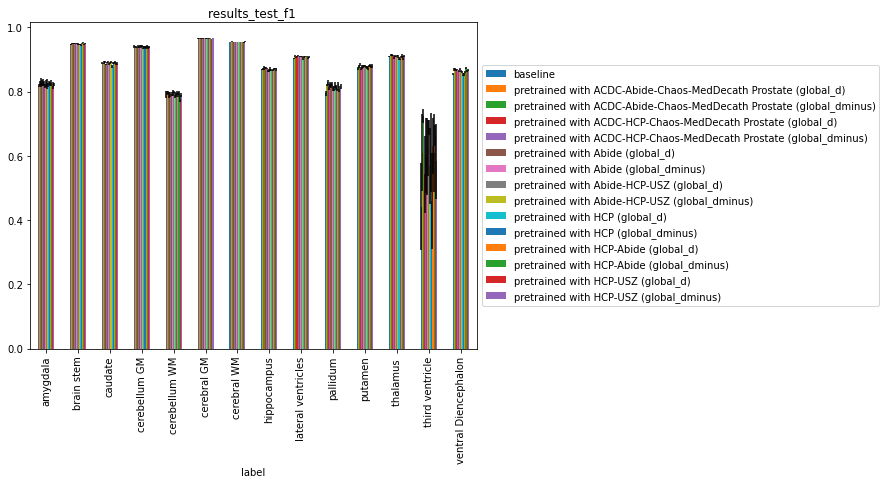

<Figure size 432x288 with 0 Axes>

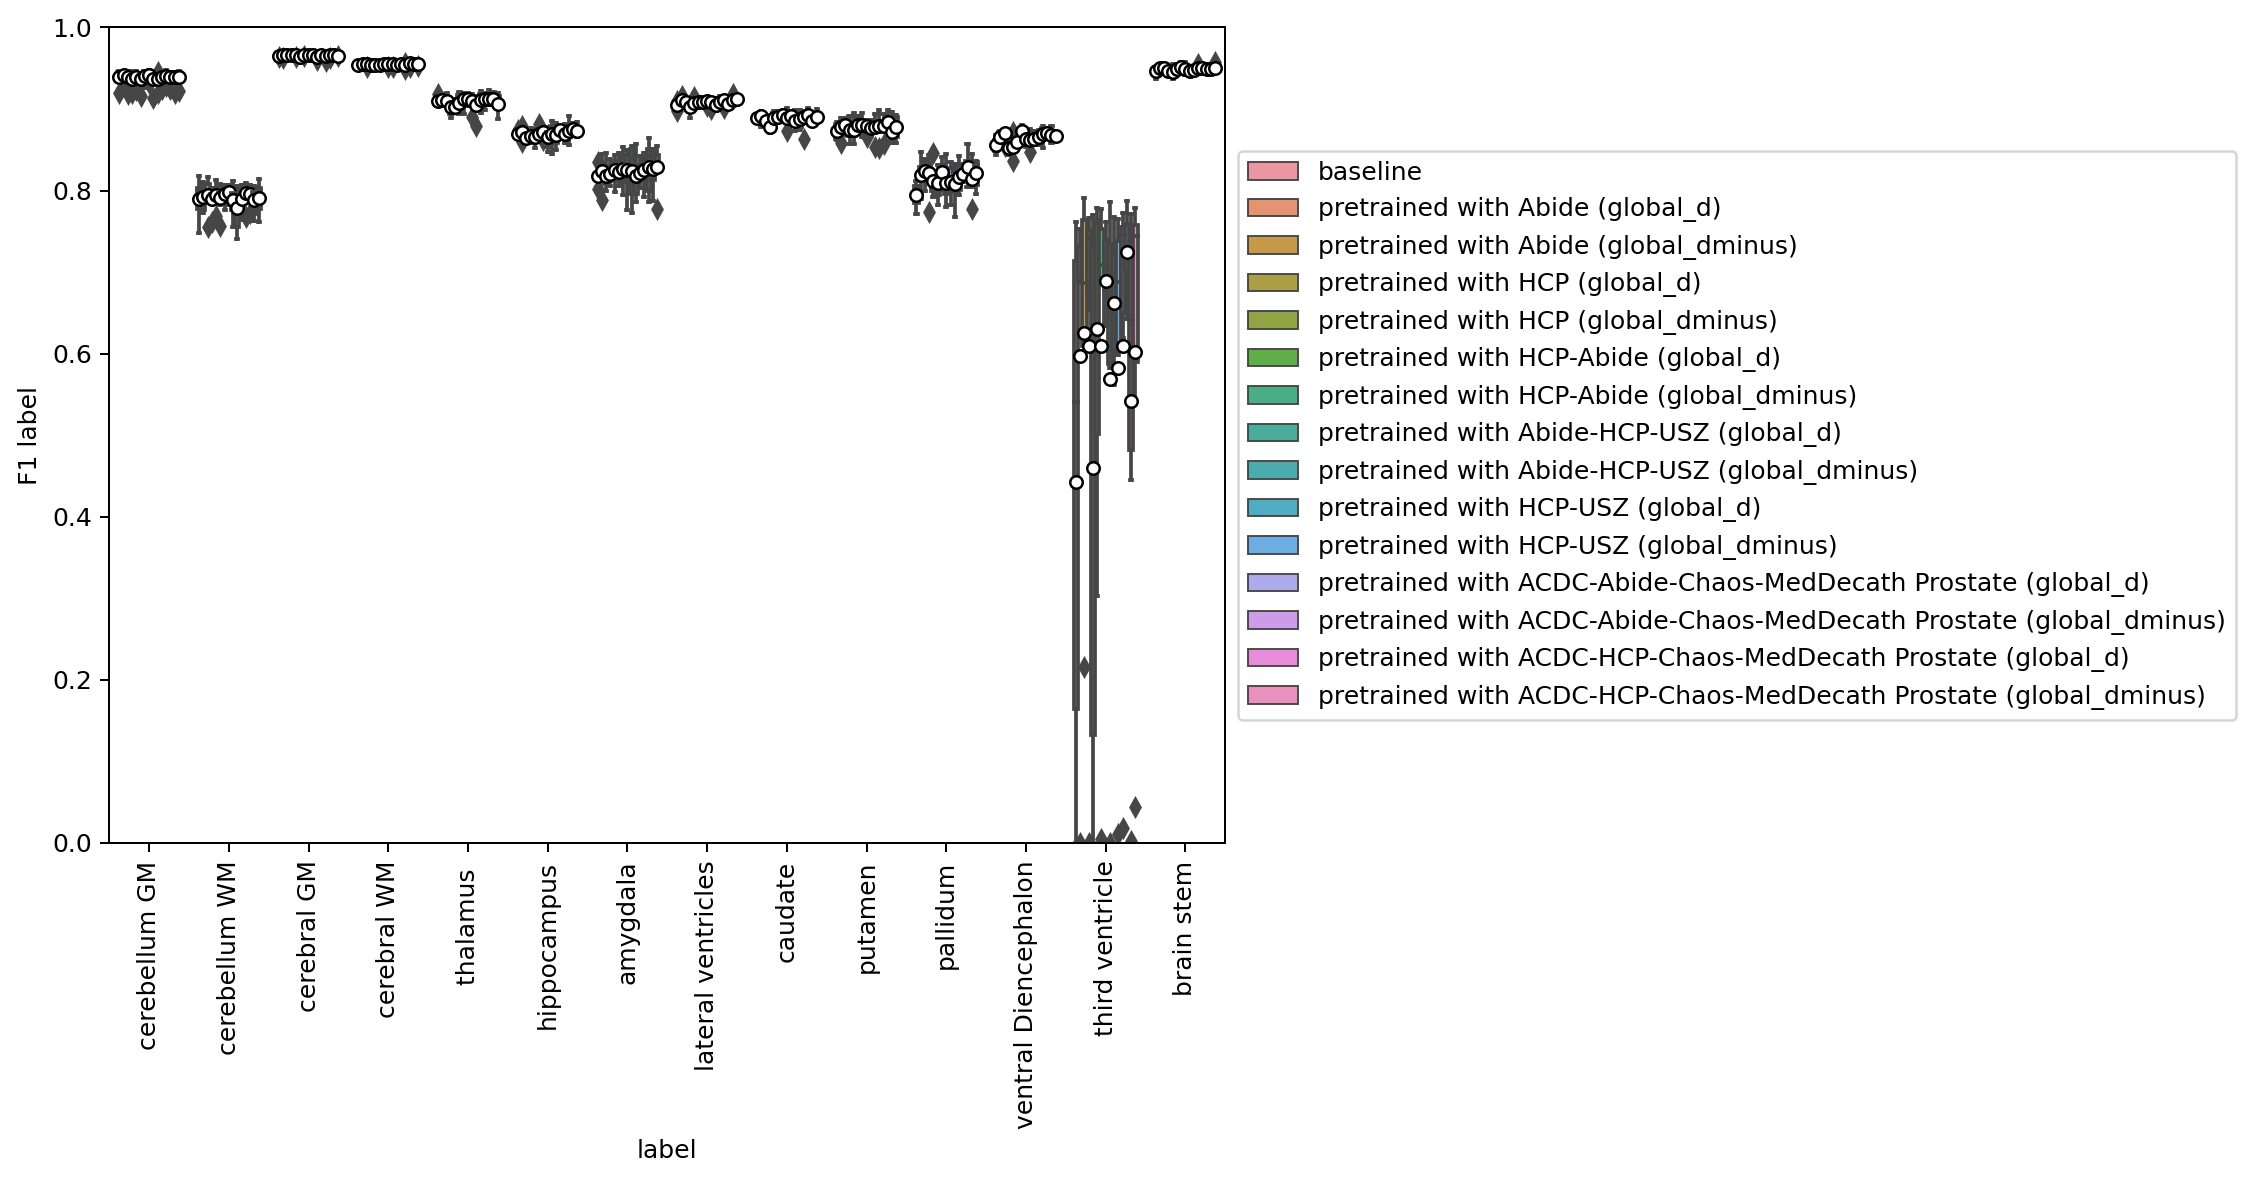

In [133]:
n_trains = [2]
results_label = plot_results_per_label(save_directory, lr, pretrainings, 
                                       n_trains, batch_sizes, losses, 'Abide','Abide_labels')
plt.figure()
results_labels, results_labels_p = boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide','ACDC_labels_boxplot_main_labels_' + str(n_trains[0]))
results_labels_p.loc[results_labels_p< 0.05]

In [131]:
ordered_diff = (results_label[results_label.index.get_level_values(1) == 'baseline'].mean(level = 0))
ordered_diff.sort_values('mean', ascending = False, inplace = True)
ordered_diff

,mean,double_std,sem
label,,,
cerebral GM,0.964750,0.004601,0.000558
cerebral WM,0.953477,0.004522,0.000548
brain stem,0.947053,0.012948,0.001570
cerebellum GM,0.938383,0.016678,0.002023
lateral ventricles,0.904397,0.015099,0.001831
thalamus,0.902982,0.026822,0.003253
caudate,0.883569,0.035036,0.004249
putamen,0.871800,0.025965,0.003149
hippocampus,0.864010,0.031644,0.003837


In [123]:
ordered_diff = (results_label[results_label.index.get_level_values(1) != 'baseline'].mean(level = 0) - results_label.xs('baseline', level = 1))
ordered_diff.sort_values('mean', ascending = False, inplace = True)
ordered_diff

,mean,double_std,sem
label,,,
third ventricle,0.136965,-0.289192,-0.064665
amygdala,0.027003,-0.039723,-0.008882
ventral Diencephalon,0.018885,-0.023902,-0.005345
hippocampus,0.009488,-0.016903,-0.003780
pallidum,0.007777,0.026707,0.005972
caudate,0.006722,-0.009342,-0.002089
putamen,0.005287,0.001444,0.000323
brain stem,0.003539,0.003730,0.000834
cerebellum GM,0.002242,-0.002161,-0.000483


In [124]:
#results_label = plot_results_per_label(save_directory, lr, pretrainings, n_trains, 
#                                       batch_sizes, losses,'Abide', 'Abide_main_labels', ordered_diff)

In [91]:
results_label

,,mean,double_std,sem
label,model,,,
amygdala,baseline,0.817736,0.019890,0.004448
brain stem,baseline,0.946887,0.011025,0.002465
caudate,baseline,0.889198,0.007905,0.001768
cerebellum GM,baseline,0.939713,0.018507,0.004138
cerebellum WM,baseline,0.790067,0.046868,0.010480
cerebral GM,baseline,0.965510,0.001420,0.000318
cerebral WM,baseline,0.953652,0.002503,0.000560
hippocampus,baseline,0.868776,0.005148,0.001151
lateral ventricles,baseline,0.904378,0.007731,0.001729


['cerebellum GM', 'cerebellum WM', 'cerebral GM', 'cerebral WM', 'thalamus ', 'hippocampus', 'amygdala', 'lateral ventricles', 'caudate', 'putamen', 'pallidum', 'ventral Diencephalon', 'third ventricle', 'brain stem']


n vol train  label          model   
2            amygdala       baseline    0
             brain stem     baseline    0
             caudate        baseline    0
             cerebellum GM  baseline    0
Name: p value, dtype: int64

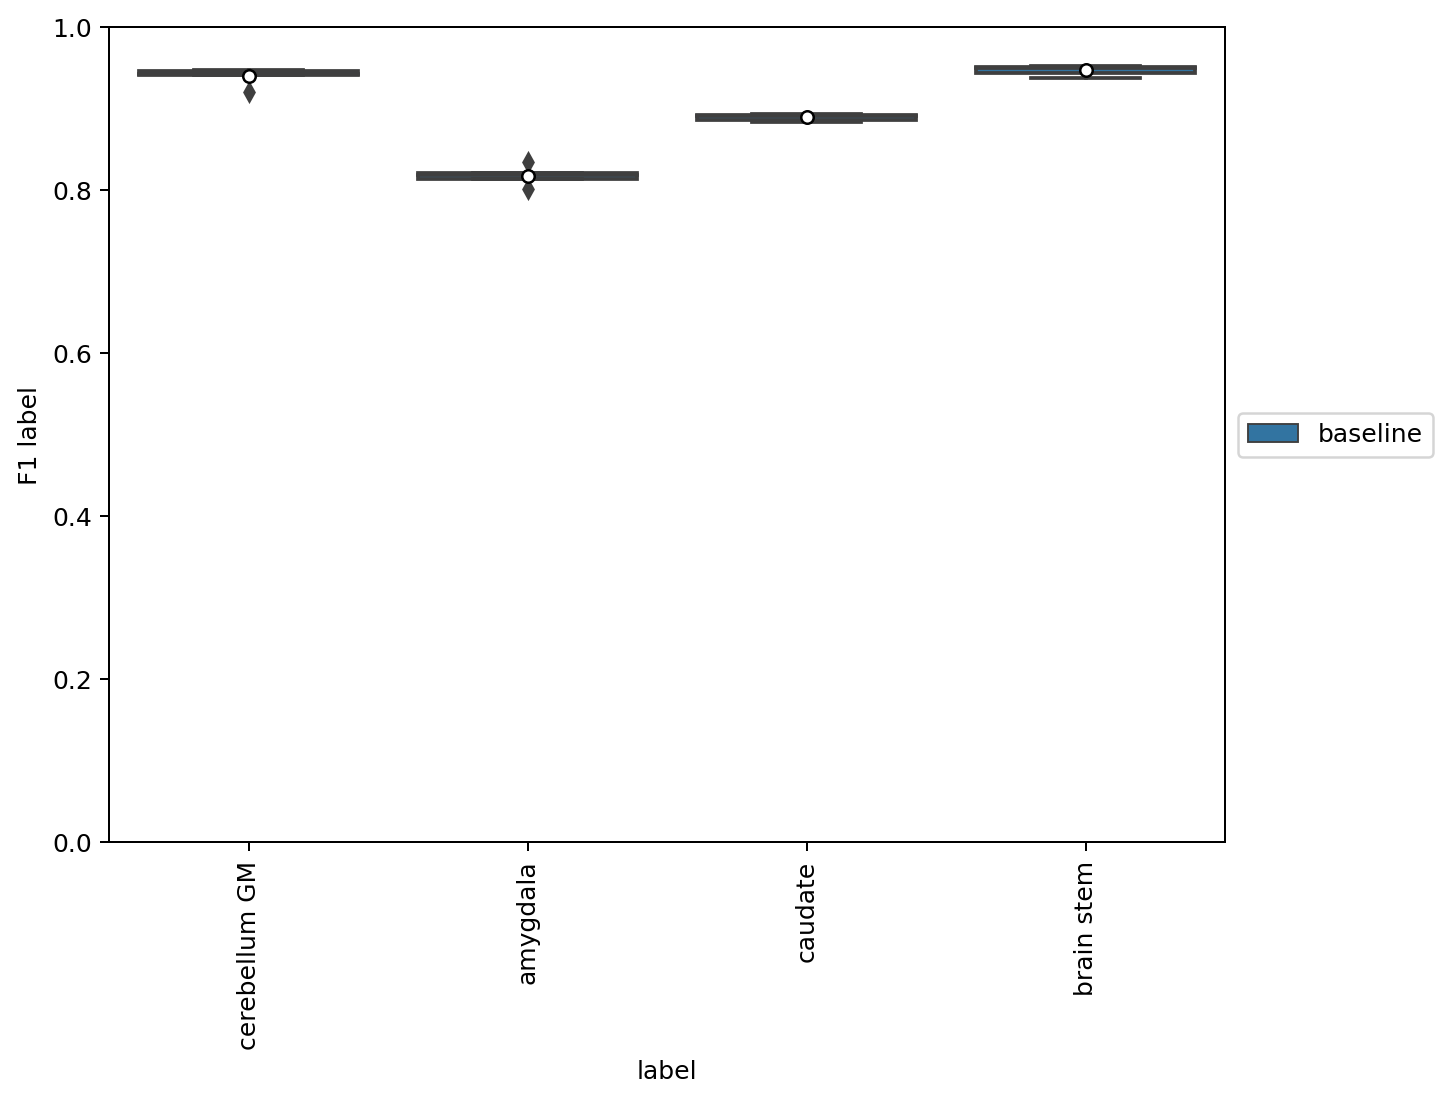

In [92]:
results_labels, results_labels_p = boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide','Abide_labels_boxplot_main_labels_' + str(n_trains[0]), ordered_diff)
results_labels_p.loc[results_labels_p< 0.05]

['cerebellum GM', 'cerebellum WM', 'cerebral GM', 'cerebral WM', 'thalamus ', 'hippocampus', 'amygdala', 'lateral ventricles', 'caudate', 'putamen', 'pallidum', 'ventral Diencephalon', 'third ventricle', 'brain stem']


<Figure size 432x288 with 0 Axes>

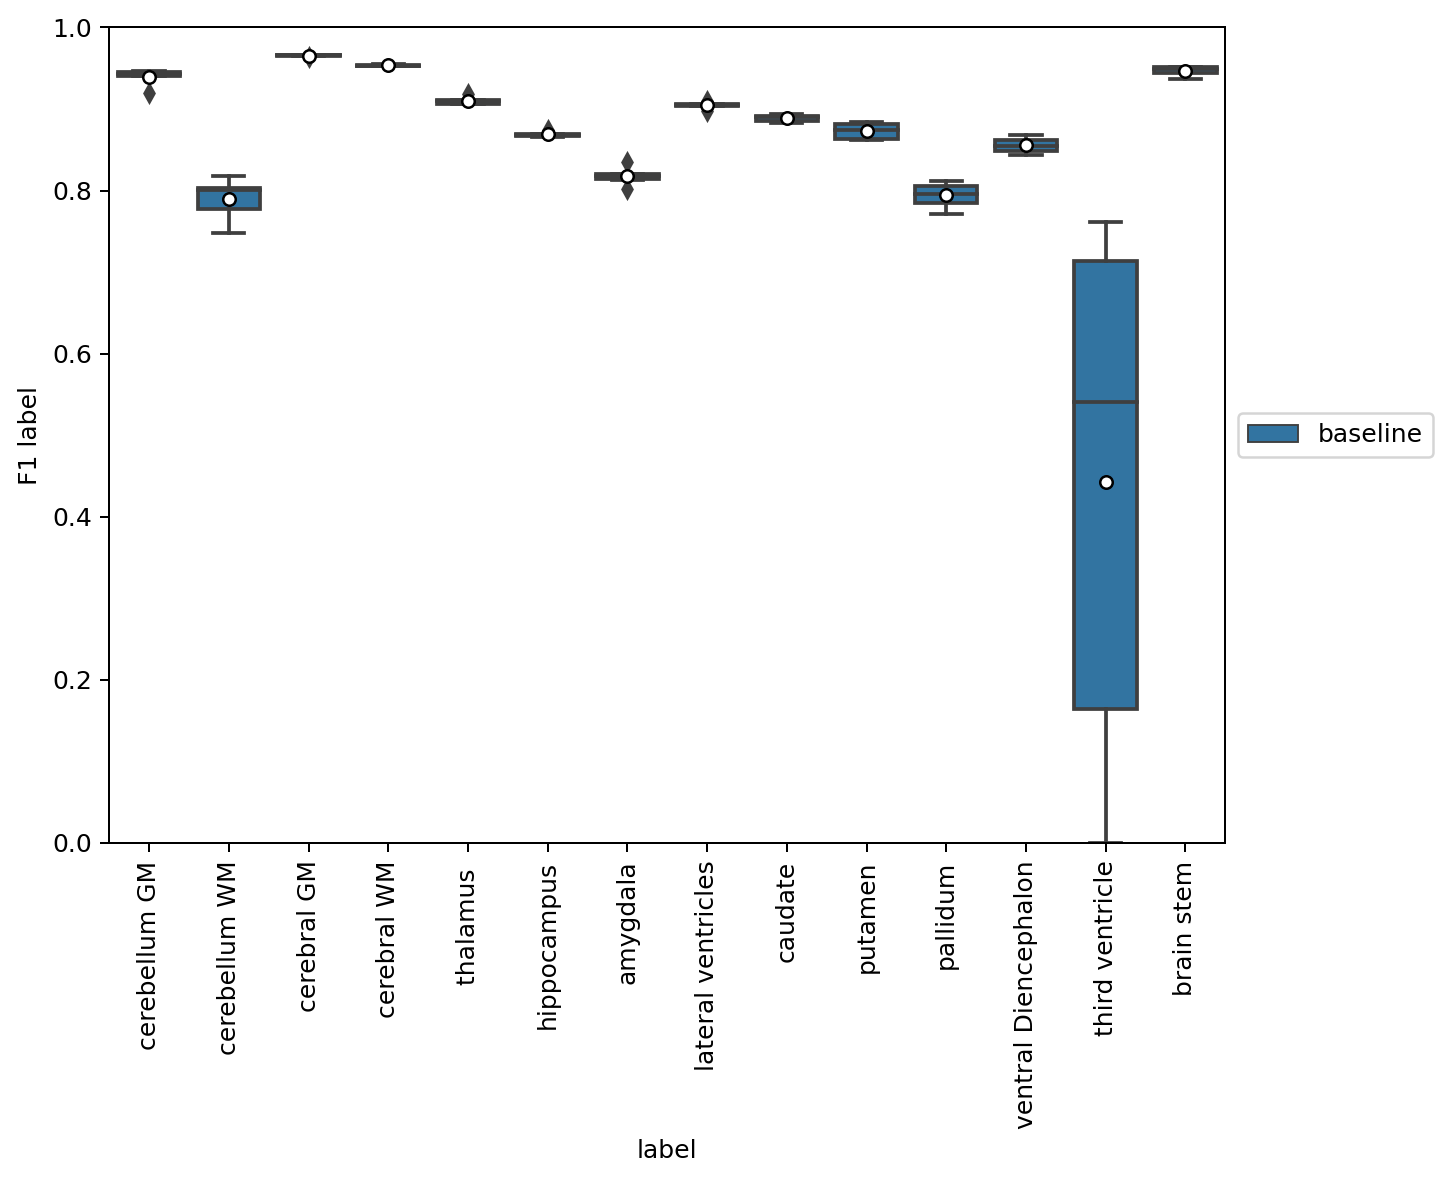

In [93]:
plt.figure()
results_labels, results_labels_p = boxplot_labels(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses, 'Abide','Abide_labels_boxplot_2')


In [31]:
(results_label.max(level = 0) - results_label.xs('baseline', level = 1)).sort_values('mean', ascending = False)

,mean,double_std,sem
label,,,
third ventricle,0.204440,0.000000,0.000000
amygdala,0.026041,0.005879,0.000713
pallidum,0.021705,0.033247,0.004032
ventral Diencephalon,0.019471,0.000000,0.000000
putamen,0.009957,0.008433,0.001023
hippocampus,0.009229,0.003229,0.000392
thalamus,0.007392,0.029657,0.003596
caudate,0.005610,0.011158,0.001353
cerebellum WM,0.005202,0.000000,0.000000


# USZ

recall  \
                                                                    mean   
n vol train model                                                          
35          baseline                                            0.706984   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.706202   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.684482   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.685372   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.684939   

                                                                           \
                                                               double_std   
n vol train model                                                           
35          baseline                                             0.070384   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...   0.072645   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...   0.099519   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...   0.123227   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...   0.060585   

                                                                          \
                                                                     sem   
n vol train model                                                          
35          baseline                                            0.017596   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.018161   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.024880   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.030807   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.015146   

                                                               precision  \
                                                                    mean   
n vol train model                                                          
35          baseline                                            0.337708   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.369612   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.382996   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.367275   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.395388   

                                                                           \
                                                               double_std   
n vol train model                                                           
35          baseline                                             0.115338   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...   0.103727   
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...   0.093176   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...   0.059777   
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...   0.123239   

                                                                          
                                                                     sem  
n vol train model                                                         
35          baseline                                            0.028834  
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.025932  
            pretrained with MMWHS-HCP-Chaos-MedDecath Prost...  0.023294  
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.014944  
            pretrained with USZ-MMWHS-Chaos-MedDecath Prost...  0.030810

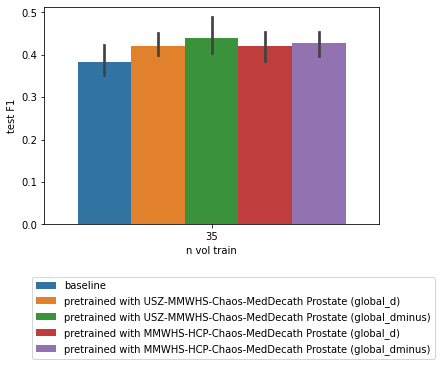

<Figure size 432x288 with 0 Axes>

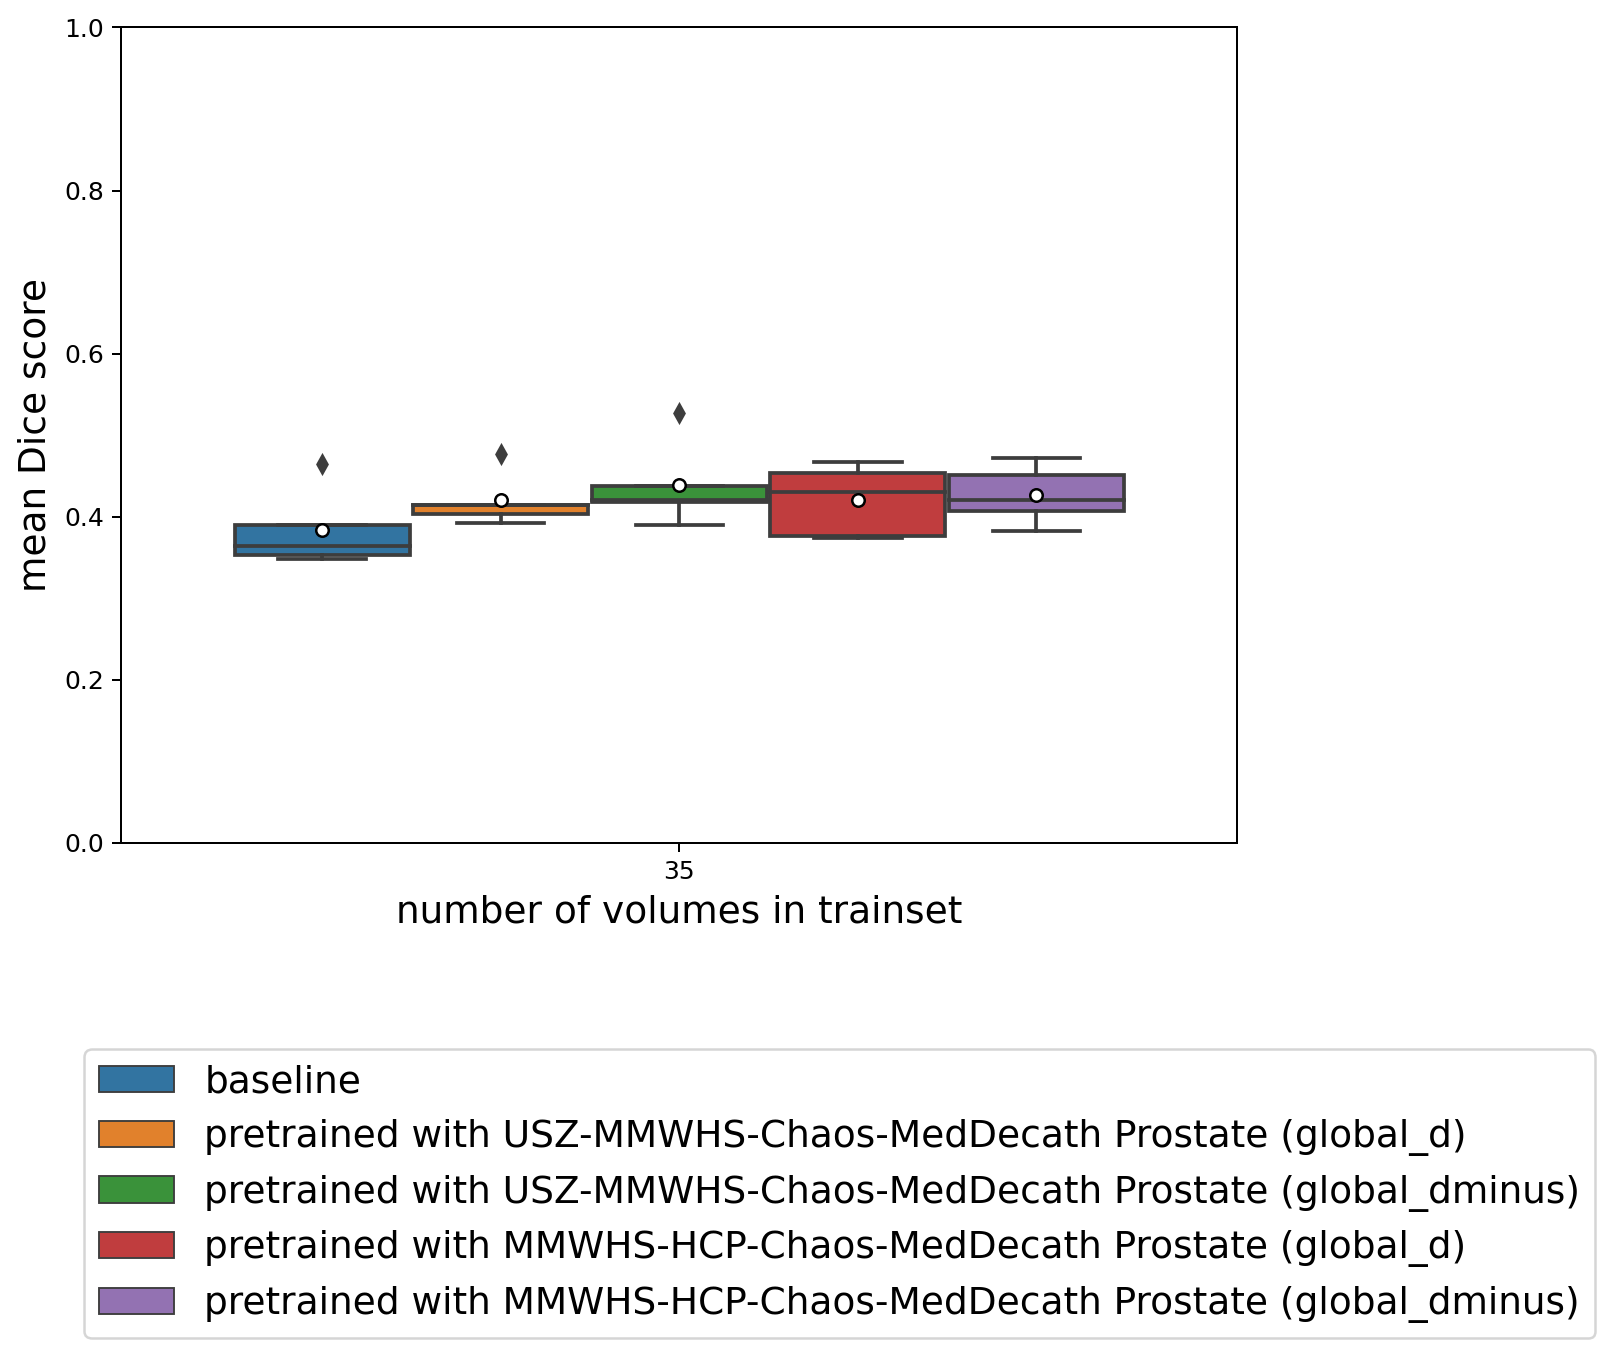

In [45]:
lr = 0.001
losses = ['crossentropy_loss']
save_directory = './trained_models/USZ/'
pretrainings = ['baseline',
#                'pretrained with USZ (global_d)',
#                'pretrained with USZ (global_dminus)',
#                'pretrained with HCP (global_d)',
#                'pretrained with HCP (global_dminus)',
#                'pretrained with USZ-HCP (global_d)',
#                'pretrained with USZ-HCP (global_dminus)',
                
#                'pretrained with USZ-HCP-Abide (global_d)',
#                'pretrained with USZ-HCP-Abide (global_dminus)',
#                'pretrained with HCP-Abide (global_d)',
#                'pretrained with HCP-Abide (global_dminus)',
#               
                'pretrained with USZ-MMWHS-Chaos-MedDecath Prostate (global_d)',
                'pretrained with USZ-MMWHS-Chaos-MedDecath Prostate (global_dminus)',
                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_d)',
                'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)',

#                 'pretrained with HCP-ACDC-Chaos-MedDecath Prostate (global_d)',
#                 'pretrained with HCP-ACDC-Chaos-MedDecath Prostate (global_dminus)',
               ]
batch_sizes  = [128]
runs = ['0','1', '2', '4', '5']

n_trains = [35]

results_test_f1, results, results_recall_precision = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'USZ_2vol', plot_loss =False, n_val = 21, recall_precision = True)

plt.figure()
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'USZ_boxplots_4D', plot_loss = False, n_val = 21)
results_recall_precision
#results_test_f1#.loc[results_test_f1['p value'] < 0.05]

In [58]:
results

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch,recall,precision,loss unet,test loss,batch_size,f1_arr,p value
0,baseline,35,"0 0.001 Name: lr, dtype: float64",NaN,0.823964,0.428205,0.389391,0.004267,0.009345,137,NaN,NaN,crossentropy_loss,0.007444,128.0,[0.3893910130055969],0


In [ ]:
# 